#Global Clustering of Midfielders: Serie A, Ligue 1 & La Liga (2023–24)

In this notebook, I’m combining midfielder data from Serie A, Ligue 1, and La Liga to construct a global clustering model. The goal is to identify cross-league tactical roles among midfielders based on their in-possession, out-of-possession, and transitional contributions.

Each league was preprocessed individually to ensure consistency:

-Cleaned raw data to standardize columns and identifiers

-Filtered players with ≥540 minutes played for tactical stability

-Selected key per-90 metrics representing distribution, progression, pressure application, and ball-winning

Key metrics include:

-Distribution: passes_total_p90, passes_key_p90, passes_accuracy_perc

-Progression: dribbles_success_p90, dribbles_success_perc, touches_total_p90

-Ball-winning: duels_total_p90, duels_won_p90, duels_win_perc, interceptions_p90, tackles_p90

-Final-third output: goals_p90, assists_p90, shots_total_p90

Team encoding: One-hot flags to retain tactical system context

Traceability is preserved via name, team, league, and position, allowing clusters to be linked back to individual players and team environments.

In this notebook, I’ll:

-Merge midfielder datasets from the three leagues

-Engineer efficiency metrics and scale tactical features

-Apply Principal Component Analysis (PCA) to reduce dimensionality

-Run K-Means clustering to identify stylistic role groups

-Interpret clusters and visualize them with centroid analysis and tactical summaries

This approach reveals tactical midfielder archetypes , allowing cross-league comparisons beyond formations or club systems.

Firstly, I am ensuring that all columns are the same for each league's dataset.

In [1]:
import pandas as pd

# --- Load and tag Serie A encoded midfielder dataset ---
df_seriea = pd.read_csv("seriea_midfielders_2023_24_preprocessed_encoded_team.csv")
df_seriea["league"] = "Serie A"

# --- Load and tag Ligue 1 encoded midfielder dataset ---
df_ligue1 = pd.read_csv("ligue1_midfielders_2023_24_preprocessed_encoded_team.csv")
df_ligue1["league"] = "Ligue 1"

# --- Load and tag La Liga encoded midfielder dataset ---
df_laliga = pd.read_csv("laliga_midfielders_2023_24_preprocessed_encoded_team.csv")
df_laliga["league"] = "La Liga"

# --- Print column names ---
print("\n📁 Serie A columns:")
print(df_seriea.columns.to_list())

print("\n📁 Ligue 1 columns:")
print(df_ligue1.columns.to_list())

print("\n📁 La Liga columns:")
print(df_laliga.columns.to_list())

# --- Preview sample rows from each dataset (including league column) ---
print("\n🔍 Serie A sample:")
print(df_seriea[["name", "team_clean", "league", "passes_total_p90", "interceptions_p90"]].head(2).to_string())

print("\n🔍 Ligue 1 sample:")
print(df_ligue1[["name", "team_clean", "league", "passes_total_p90", "interceptions_p90"]].head(2).to_string())

print("\n🔍 La Liga sample:")
print(df_laliga[["name", "team_clean", "league", "passes_total_p90", "interceptions_p90"]].head(2).to_string())



📁 Serie A columns:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api', 'shots_on_target_api', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api', 'passes_accuracy_perc', 'tackles_total_api', 'interceptions_total_api', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'duels_total_p90', 'duels_won_p90', 'goals_p90', 'shots_total_p90', 'shots_on_target_p90', 'assists_p90', 'dribbles_attempts_p90', 'dribbles_success_p90', 'touches_total_p90', 'passes_key_p90', 'passes_total_p90', 'tackles_p90', 'interceptions_p90', 'team_AS Roma', 'team_Atalanta', 'team_Bologna', 'team_Cagliari', 'team_Empoli', 'team_Fiorentina', 'team_Frosinone', 'team_Genoa', 'team_Inter', 'team_Juventus', 'team_Lazio', 'team_Lecce', 'team_Monza', 'team_Napoli', 'team_Salernitana', 'team_Sassuolo', 'team_Torino', 'team_Udinese', 'team_Verona', 'league']

📁 Ligue 1

Before merging or scaling the midfielders datasets, I’m checking each one for missing values. This helps identify any columns that need to be dropped, imputed, or handled carefully to avoid errors in clustering or PCA.

In [2]:
# --- Missing value count per column (Serie A) ---
print("\n🔎 Missing values in Serie A:")
print(df_seriea.isnull().sum().sort_values(ascending=False))

# --- Missing value count per column (Ligue 1) ---
print("\n🔎 Missing values in Ligue 1:")
print(df_ligue1.isnull().sum().sort_values(ascending=False))

# --- Missing value count per column (La Liga) ---
print("\n🔎 Missing values in La Liga:")
print(df_laliga.isnull().sum().sort_values(ascending=False))



🔎 Missing values in Serie A:
name                       0
position                   0
minutes                    0
duels_total_api            0
duels_won_api              0
goals_total_api            0
shots_total_api            0
shots_on_target_api        0
assists_total_api          0
dribbles_attempts_api      0
dribbles_success_api       0
touches_total_api          0
passes_key_api             0
passes_total_api           0
passes_accuracy_perc       0
tackles_total_api          0
interceptions_total_api    0
shots_on_target_perc       0
dribbles_success_perc      0
name_clean                 0
team_clean                 0
duels_total_p90            0
duels_won_p90              0
goals_p90                  0
shots_total_p90            0
shots_on_target_p90        0
assists_p90                0
dribbles_attempts_p90      0
dribbles_success_p90       0
touches_total_p90          0
passes_key_p90             0
passes_total_p90           0
tackles_p90                0
interceptions

No missing values.

#1. Merging the 3 datasets

With all three league datasets cleaned and consistently labeled, I’m now merging them into one global DataFrame. This combined pool includes all preprocessed metrics, one-hot encoded team flags, and identifiers like name, team_clean, and league. It’s the foundation for global feature scaling and clustering. I am also adding the column 'league' as it was missing from all the datasets.

In [3]:
import pandas as pd

# --- Load preprocessed, team-encoded midfielder datasets ---
df_seriea = pd.read_csv("seriea_midfielders_2023_24_preprocessed_encoded_team.csv")
df_ligue1 = pd.read_csv("ligue1_midfielders_2023_24_preprocessed_encoded_team.csv")
df_laliga = pd.read_csv("laliga_midfielders_2023_24_preprocessed_encoded_team.csv")

# --- Add league identifiers manually (for traceability during clustering)
df_seriea["league"] = "Serie A"
df_ligue1["league"] = "Ligue 1"
df_laliga["league"] = "La Liga"

# --- Merge datasets into a unified global dataframe
df_global_midfielders_raw = pd.concat([df_seriea, df_ligue1, df_laliga], ignore_index=True)

# --- Save merged output to file
df_global_midfielders_raw.to_csv("global_midfielders_2023_24_encoded.csv", index=False)
print(f"✅ Global midfielder dataset saved — shape: {df_global_midfielders_raw.shape}")

# --- Sanity check sample
print(df_global_midfielders_raw[["name", "team_clean", "league", "passes_total_p90", "interceptions_p90"]].head())


✅ Global midfielder dataset saved — shape: (294, 88)
             name   team_clean   league  passes_total_p90  interceptions_p90
0     A. Candreva  salernitana  Serie A         37.220007           0.228344
1    K. Strootman        genoa  Serie A         47.568238           0.521092
2   Joan Gonzàlez        lecce  Serie A         31.167315           0.350195
3    Luis Alberto        lazio  Serie A         58.319690           0.271435
4  R. Gagliardini        monza  Serie A         55.793919           1.178209


#2. EDA (EXPLORATORY DATA ANALYSIS)

Before initiating PCA and clustering, this section provides a tactical overview of the global midfielders dataset for the 2023–24 season. It summarizes key performance metrics—normalized per 90 minutes or expressed as percentages—and inspects missing values, average contributions, and metric classifications. By reviewing variables like goals, shot volume, passing, dribbling, and duels across leagues, we establish a contextual foundation to interpret cluster results and ensure modeling transparency.

In [4]:
import pandas as pd

# --- Load the encoded global midfielder dataset ---
try:
    df_global_encoded = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Global midfielder dataset loaded successfully for EDA overview.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Section Intro ---
print("\n# 2. EDA (Exploratory Data Analysis)")
print("## 2.1 Tactical Overview of Global Midfielder Pool")
print("This section previews identifiers and contribution metrics used for clustering, checking structure, completeness, and average values across the dataset.")

# --- Identifier Columns ---
identifier_columns = [
    "name", "name_clean", "team", "team_clean", "league", "minutes", "position"
]

print("\n### Identifier Variables:")
existing_ids = [col for col in identifier_columns if col in df_global_encoded.columns]
for col in existing_ids:
    print(f"    * {col}")

# --- Clustering Metrics ---
clustering_metrics = [
    "minutes", "goals_p90", "assists_p90", "shots_total_p90", "passes_key_p90",
    "passes_total_p90", "passes_accuracy_perc", "dribbles_success_p90",
    "dribbles_success_perc", "duels_total_p90", "duels_won_p90",
    "interceptions_p90", "tackles_p90"
]

print("\n### Performance Metrics Used for Clustering:")
existing_metrics = [col for col in clustering_metrics if col in df_global_encoded.columns]
for metric in existing_metrics:
    print(f"    * {metric}")

# --- Dataset Dimensions ---
print(f"\n### Dataset Overview:")
print(f"    * Total Players: {df_global_encoded.shape[0]}")
print(f"    * Total Columns: {df_global_encoded.shape[1]}")

# --- Missing Values Check (Safeguarded) ---
missing_check_cols = existing_ids + existing_metrics
missing_values = df_global_encoded[missing_check_cols].isnull().sum()
missing_summary = missing_values[missing_values > 0]

if missing_summary.empty:
    print("    ✅ No missing values detected in key columns.")
else:
    print("    ⚠️ Missing values found:")
    print(missing_summary.to_string())

# --- Mean Values of Clustering Metrics ---
print("\n### Mean Contribution Metrics Across Global Pool:")
for metric in existing_metrics:
    avg = df_global_encoded[metric].mean()
    unit = "%" if "perc" in metric else ""
    print(f"    * {metric}: {avg:.2f}{unit}")


✅ Global midfielder dataset loaded successfully for EDA overview.

# 2. EDA (Exploratory Data Analysis)
## 2.1 Tactical Overview of Global Midfielder Pool
This section previews identifiers and contribution metrics used for clustering, checking structure, completeness, and average values across the dataset.

### Identifier Variables:
    * name
    * name_clean
    * team_clean
    * league
    * minutes
    * position

### Performance Metrics Used for Clustering:
    * minutes
    * goals_p90
    * assists_p90
    * shots_total_p90
    * passes_key_p90
    * passes_total_p90
    * passes_accuracy_perc
    * dribbles_success_p90
    * dribbles_success_perc
    * duels_total_p90
    * duels_won_p90
    * interceptions_p90
    * tackles_p90

### Dataset Overview:
    * Total Players: 294
    * Total Columns: 88
    ✅ No missing values detected in key columns.

### Mean Contribution Metrics Across Global Pool:
    * minutes: 1765.02
    * goals_p90: 0.11
    * assists_p90: 0.10
    * shots

# 2. EDA (Exploratory Data Analysis)

## 2.1 Tactical Overview of Global Midfielder Pool

This section previews identifiers and contribution metrics used for clustering, checking structure, completeness, and average values across the dataset.

---

### Identifier Variables:

- name  
- name_clean  
- team_clean  
- league  
- minutes  
- position

---

### Performance Metrics Used for Clustering:

- minutes  
- goals_p90  
- assists_p90  
- shots_total_p90  
- passes_key_p90  
- passes_total_p90  
- passes_accuracy_perc  
- dribbles_success_p90  
- dribbles_success_perc  
- duels_total_p90  
- duels_won_p90  
- interceptions_p90  
- tackles_p90

---

### Dataset Overview:

- Total Players: 294  
- Total Columns: 88  
✅ No missing values detected in key columns.

---

### Mean Contribution Metrics Across Global Pool:

- minutes: 1765.02  
- goals_p90: 0.11  
- assists_p90: 0.10  
- shots_total_p90: 0.93  
- passes_key_p90: 1.19  
- passes_total_p90: 44.76  
- passes_accuracy_perc: 61.88%  
- dribbles_success_p90: 0.89  
- dribbles_success_perc: 53.37%  
- duels_total_p90: 10.19  
- duels_won_p90: 5.02  
- interceptions_p90: 0.83  
- tackles_p90: 1.89


Following I am plotting distributions of key metrics for midfielders to understand typical player behavior and detect skewness. These visualizations help us grasp how common or rare certain statistical outputs are for midfielders.

✅ Encoded global midfielder dataset loaded for metric distribution plots.


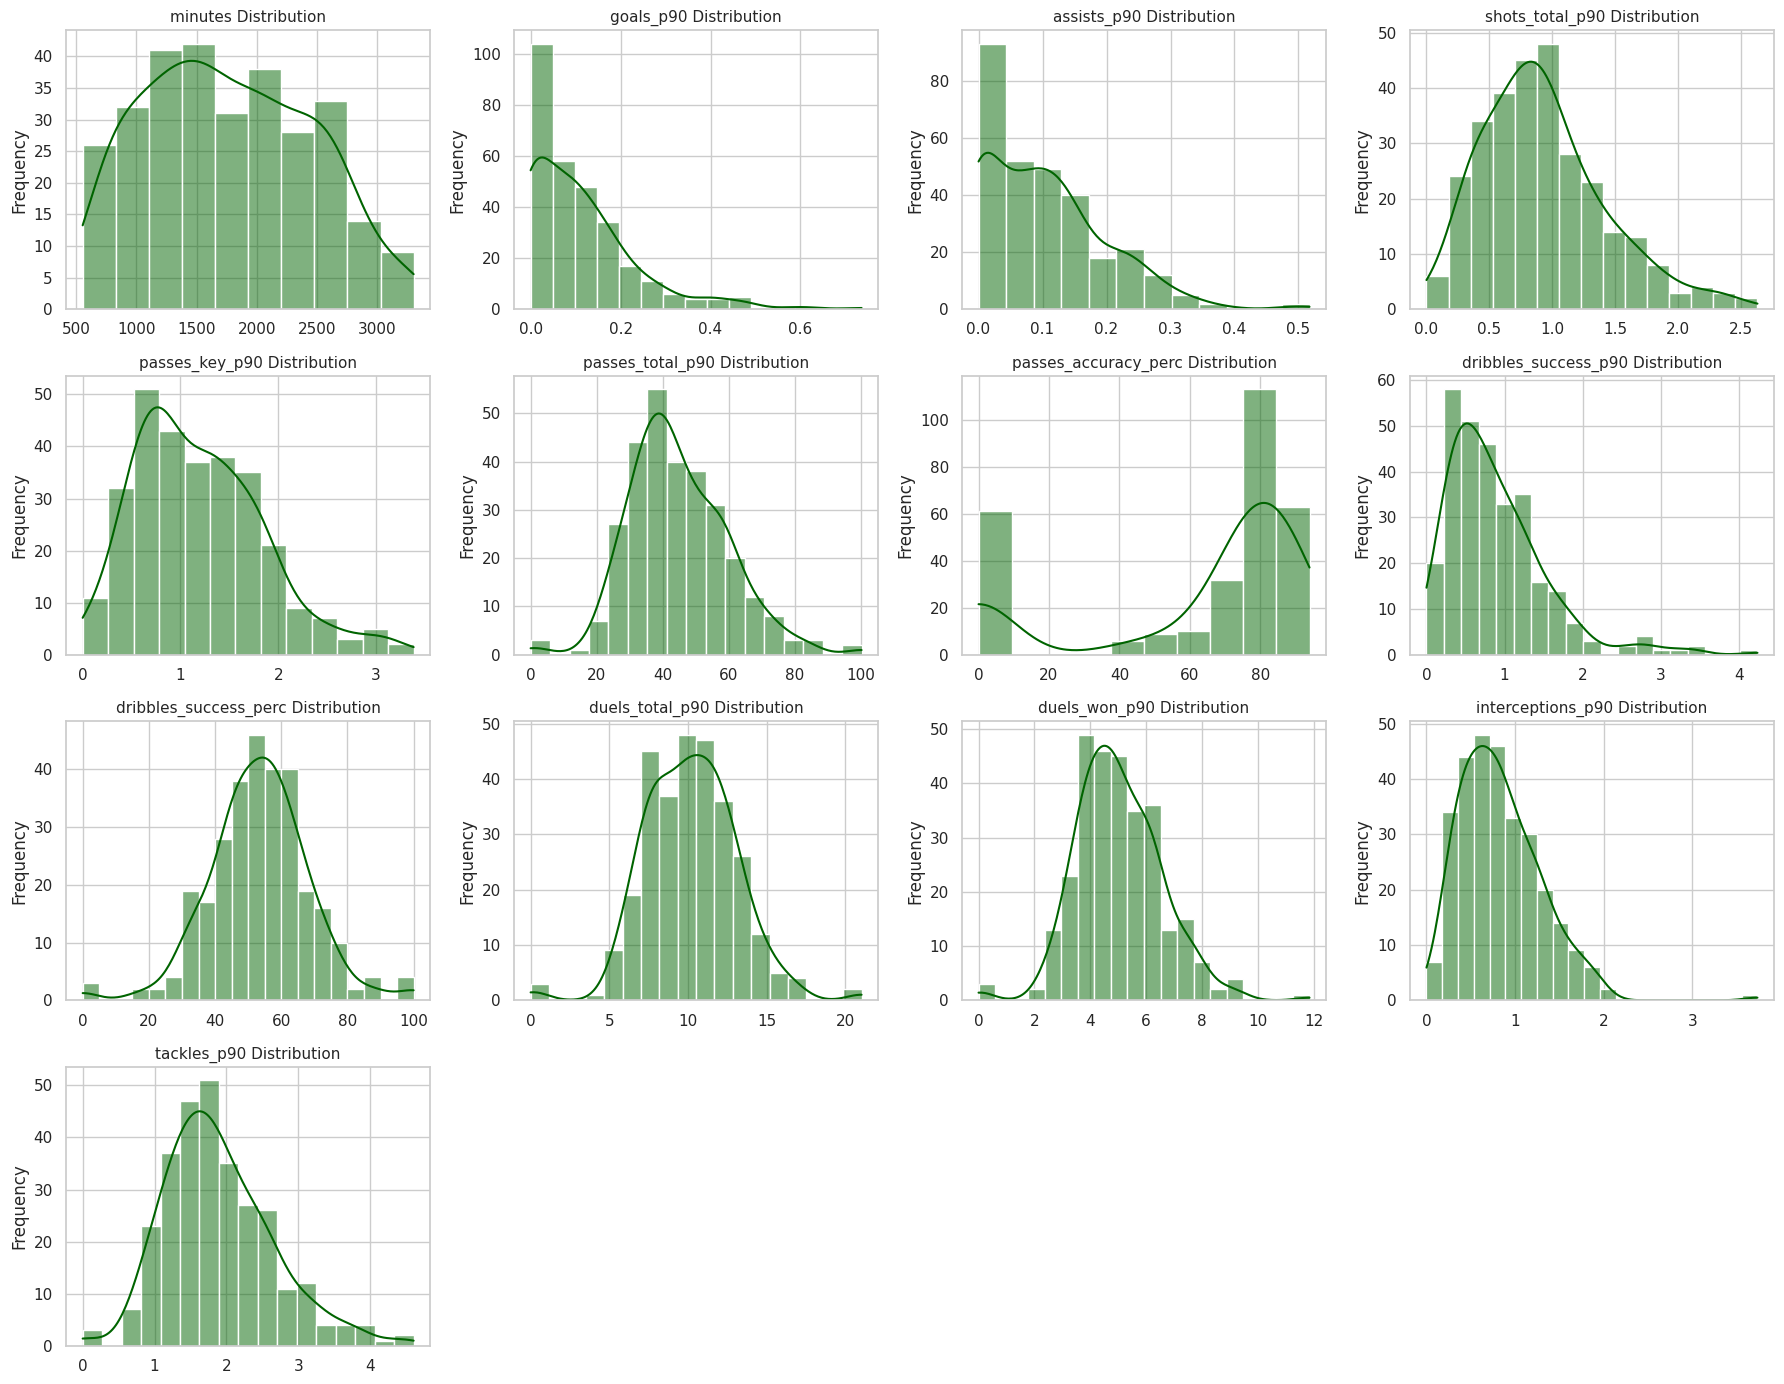

✅ Distribution plots for global midfielder metrics generated successfully.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Set Seaborn visual style ---
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 14)

# --- Load the encoded global midfielder dataset ---
try:
    df_global_encoded = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Encoded global midfielder dataset loaded for metric distribution plots.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define performance metrics used in clustering ---
key_metrics = [
    "minutes", "goals_p90", "assists_p90", "shots_total_p90",
    "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90",
    "interceptions_p90", "tackles_p90"
]

# --- Create subplot grid ---
num_metrics = len(key_metrics)
ncols = 4
nrows = (num_metrics + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
axes = axes.flatten()

# --- Plot each feature with KDE overlay ---
for i, metric in enumerate(key_metrics):
    if metric in df_global_encoded.columns:
        sns.histplot(data=df_global_encoded, x=metric, kde=True, ax=axes[i], color='darkgreen')
        axes[i].set_title(f"{metric} Distribution", fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frequency")
    else:
        print(f"⚠️ '{metric}' not found in dataset. Skipping.")
        fig.delaxes(axes[i])

# --- Remove empty axes if any ---
for j in range(num_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("✅ Distribution plots for global midfielder metrics generated successfully.")


#Key Takeaways from the Distribution Plots – Global Midfielders

These visualizations provide insights into how the filtered group of global midfielders (Serie A, Ligue 1, and La Liga) operate across the pitch, highlighting their contributions in defending, ball circulation, progression, and attacking output.

**Defensive Actions**

*   **duels_total_p90 and duels_won_p90:** These distributions appear somewhat right-skewed, indicating that while most midfielders engage in a moderate number of defensive actions, there's a smaller group of players who are significantly more active defensively. This suggests distinct roles within the midfield in terms of defensive contribution across the three leagues.
*   **tackles_p90 and interceptions_p90:** These distributions show variations in defensive contribution through direct action and anticipation. Most global midfielders perform a relatively low number of tackles and interceptions per 90. However, the distributions show tails extending to higher values, identifying players who are more proactive in regaining possession through tackles and reading the game for interceptions.

**Ball Circulation and Volume**

*   **passes_total_p90:** This metric shows a wide range of involvement in ball circulation. While there's a concentration of players with moderate passing volumes, some midfielders register very high numbers of passes per 90, indicating roles centered around controlling possession and distributing the ball frequently. The distribution appears somewhat normally distributed with a slight right skew.
*   **passes_key_p90:** The distribution for key passes is heavily skewed towards lower values, with most midfielders creating a small number of key passes per 90. A few players stand out with significantly higher key pass volumes, highlighting their role as primary creative outlets.
*   **passes_accuracy_perc:** The distribution of passing accuracy appears somewhat left-skewed, with a cluster of players having higher passing accuracy. This indicates that a good portion of midfielders in these leagues maintain a relatively high success rate in their passing, which is crucial for maintaining possession and progressing the ball effectively.

**Ball Progression**

*   **dribbles_success_p90 and dribbles_success_perc:** Both dribbling metrics are heavily skewed towards lower values. This suggests that successful dribbling is not a primary feature for the majority of midfielders in these leagues, but a select few players excel in this area, indicating roles that involve carrying the ball forward and breaking lines through individual skill.

**Attacking Output**

*   **goals_p90, assists_p90, and shots_total_p90:** These metrics are all heavily skewed towards zero, with a long tail extending to higher values. This is expected for midfielders, as scoring and assisting are often secondary contributions compared to forwards. However, the tails identify midfielders who contribute significantly to their team's attack through goals, assists, and shot volume, suggesting more advanced or box-to-box roles.

**Workload/Involvement**

*   **minutes:** The distribution of minutes played shows a varied range, with a concentration around the average (1765.02 minutes). There's a tail extending to higher minutes, representing core players who are consistently involved throughout the season, as well as players with fewer minutes, likely due to rotation, injuries, or squad depth.
* **touches_total_p90**: The distribution of total touches per 90 minutes is likely to be somewhat similar to `passes_total_p90`, indicating a general involvement in the game. Midfielders with higher touches are likely to be more central to their team's play, involved in building up play and circulating the ball.

Overall, the distributions highlight the diverse tactical roles within the global midfielder pool across Serie A, Ligue 1, and La Liga, ranging from defensively focused players to those with high creative output or significant involvement in possession. These variations will be crucial in identifying distinct clusters later in the analysis.

I am creating a heatmap to visualize correlations between tactical features

-This helps identify which stats tend to move together and which ones are independent

-Useful to understand potential clusters and avoid feature redundancy

✅ Encoded global midfielder dataset loaded successfully for correlation analysis.


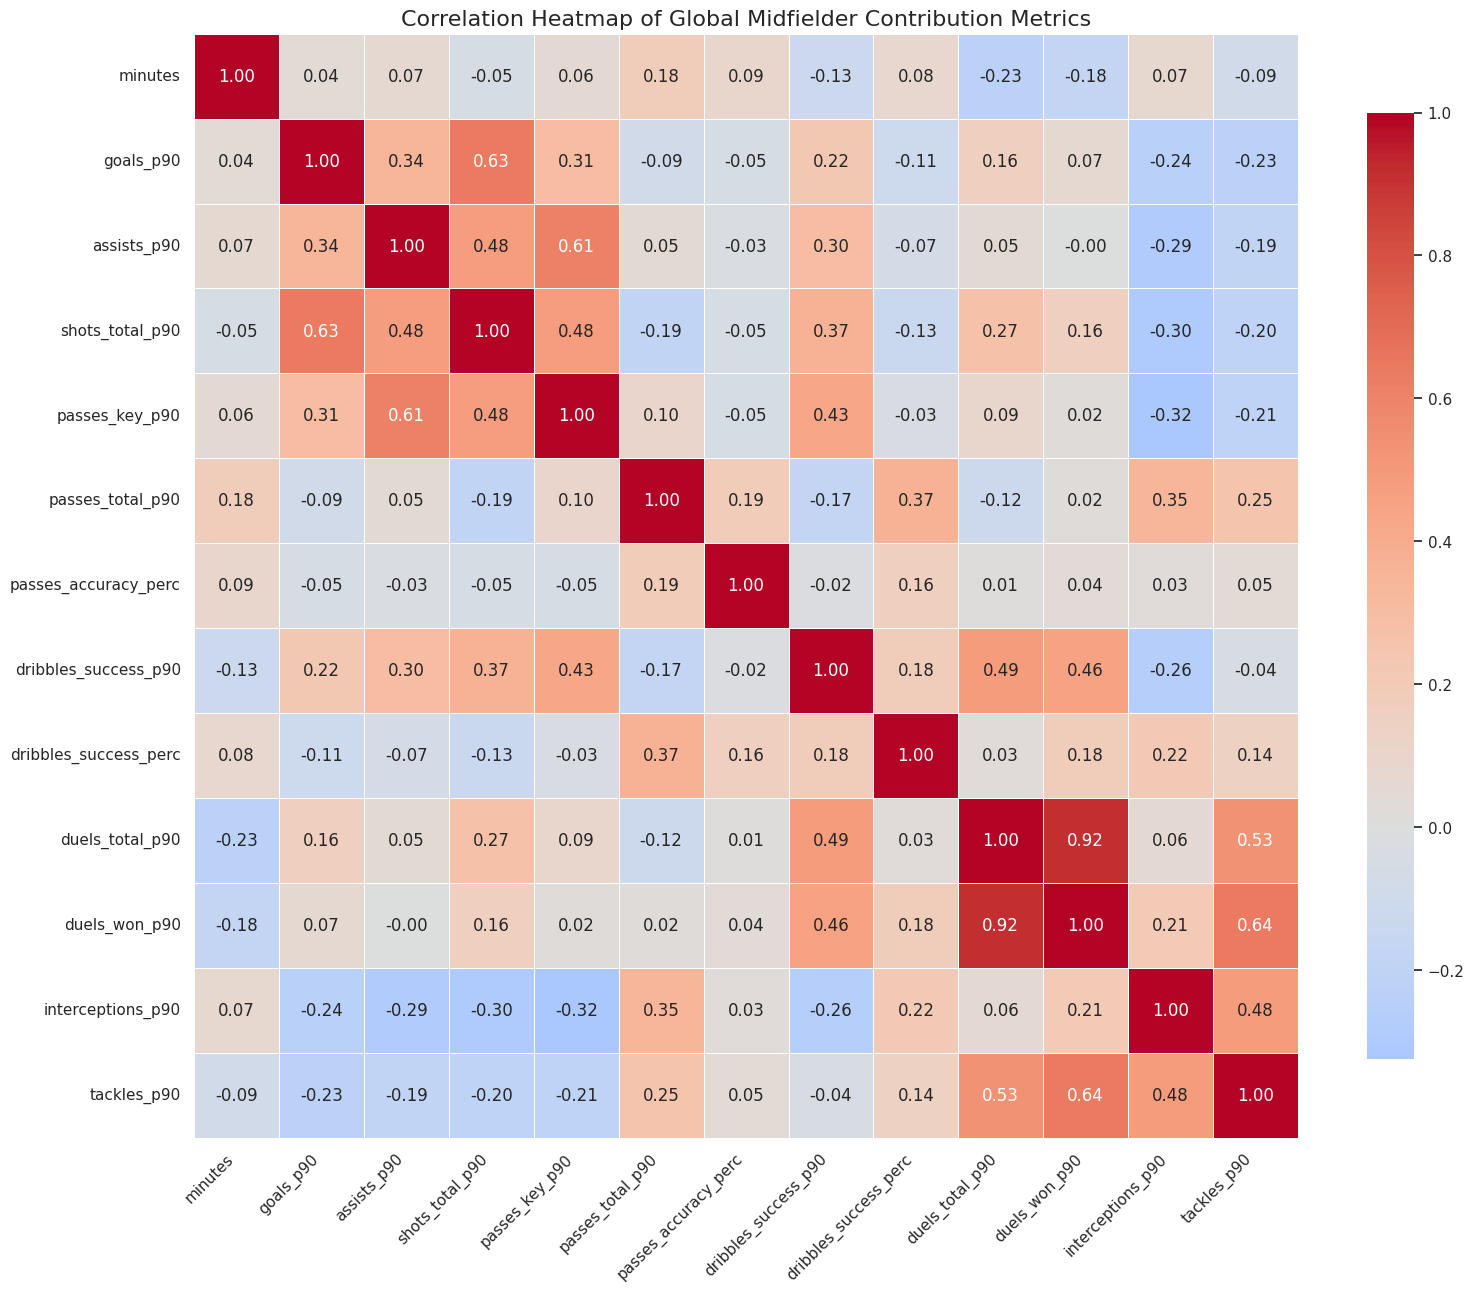

✅ Correlation heatmap generated successfully.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Set Seaborn style ---
sns.set(style="whitegrid")

# --- Load encoded global midfielder dataset ---
try:
    df_global_encoded = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Encoded global midfielder dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Define relevant metrics for clustering ---
corr_metrics = [
    "minutes", "goals_p90", "assists_p90", "shots_total_p90",
    "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90",
    "interceptions_p90", "tackles_p90"
]

# --- Safeguard: Keep only existing columns ---
valid_corr_metrics = [m for m in corr_metrics if m in df_global_encoded.columns]

if not valid_corr_metrics:
    print("❌ No valid metrics found for correlation analysis.")
else:
    # --- Compute and plot correlation matrix ---
    corr_matrix = df_global_encoded[valid_corr_metrics].corr()

    plt.figure(figsize=(16, 14))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .75}
    )
    plt.title("Correlation Heatmap of Global Midfielder Contribution Metrics", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("✅ Correlation heatmap generated successfully.")


#Interpretation of the Correlation Heatmap – Global Midfielders

The heatmap visualizes the pairwise correlations between the selected per-90 and percentage metrics for global midfielders. The values range from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no correlation.

Here are some key observations:

**Strong Positive Correlations:**

*   **duels_total_p90 and duels_won_p90:** As expected, there is a very strong positive correlation (around 0.92) between the total number of duels a player is involved in and the number of duels they win. This suggests that players who engage in more duels also tend to win a proportional number of them.
*   **shots_total_p90 and goals_p90:** There is a strong positive correlation (around 0.63) between the total shots taken and the goals scored. This is intuitive, as taking more shots generally leads to scoring more goals.
*   **passes_key_p90 and assists_p90:** There is a strong positive correlation (around 0.61) between key passes and assists, highlighting that players who create more chances (key passes) are also more likely to register assists.

**Moderate Positive Correlations:**

*   **tackles_p90 and interceptions_p90:** There is a moderate positive correlation (around 0.48) between tackles and interceptions, suggesting that players who are active in one area of defensive action also tend to be active in the other.
*   **duels_won_p90 and tackles_p90:** A moderate positive correlation (around 0.64) exists, indicating that winning duels is related to making tackles.
*   **dribbles_success_p90 and passes_key_p90:** There is a moderate positive correlation (around 0.43) between successful dribbles and key passes, suggesting that players who are good at dribbling can also create scoring opportunities.
*   **dribbles_success_p90 and duels_total_p90:** A moderate positive correlation (around 0.49) exists, suggesting players who engage in more duels also tend to have more successful dribbles.
*   **dribbles_success_p90 and duels_won_p90:** A moderate positive correlation (around 0.46) exists, indicating that winning duels is related to having successful dribbles.

**Weak or No Significant Correlations:**

*   **minutes** generally shows weak correlations with most performance metrics, which is expected as playing time doesn't directly correlate with specific per-90 contributions.
*   **passes_accuracy_perc** shows weak correlations with most other metrics, suggesting that while important, passing accuracy doesn't strongly predict other types of contributions in this dataset.
*   **interceptions_p90** shows moderate negative correlations with attacking metrics like `goals_p90`, `assists_p90`, and `shots_total_p90`, which is intuitive as players focused on interceptions may be less involved in attacking phases.

Overall, the heatmap confirms expected relationships between certain metrics (e.g., duels and duels won, shots and goals) and reveals other interesting connections (e.g., dribbling success with key passes and duels). These relationships will be considered during feature selection and dimensionality reduction for clustering.

I am plotting boxplots to detect outliers and visualize distribution spread.
This helps identify which players (or roles) stand out significantly from the average behavior.

✅ Encoded global midfielder dataset loaded successfully for boxplot analysis.

--- Generating Boxplot Visualizations ---


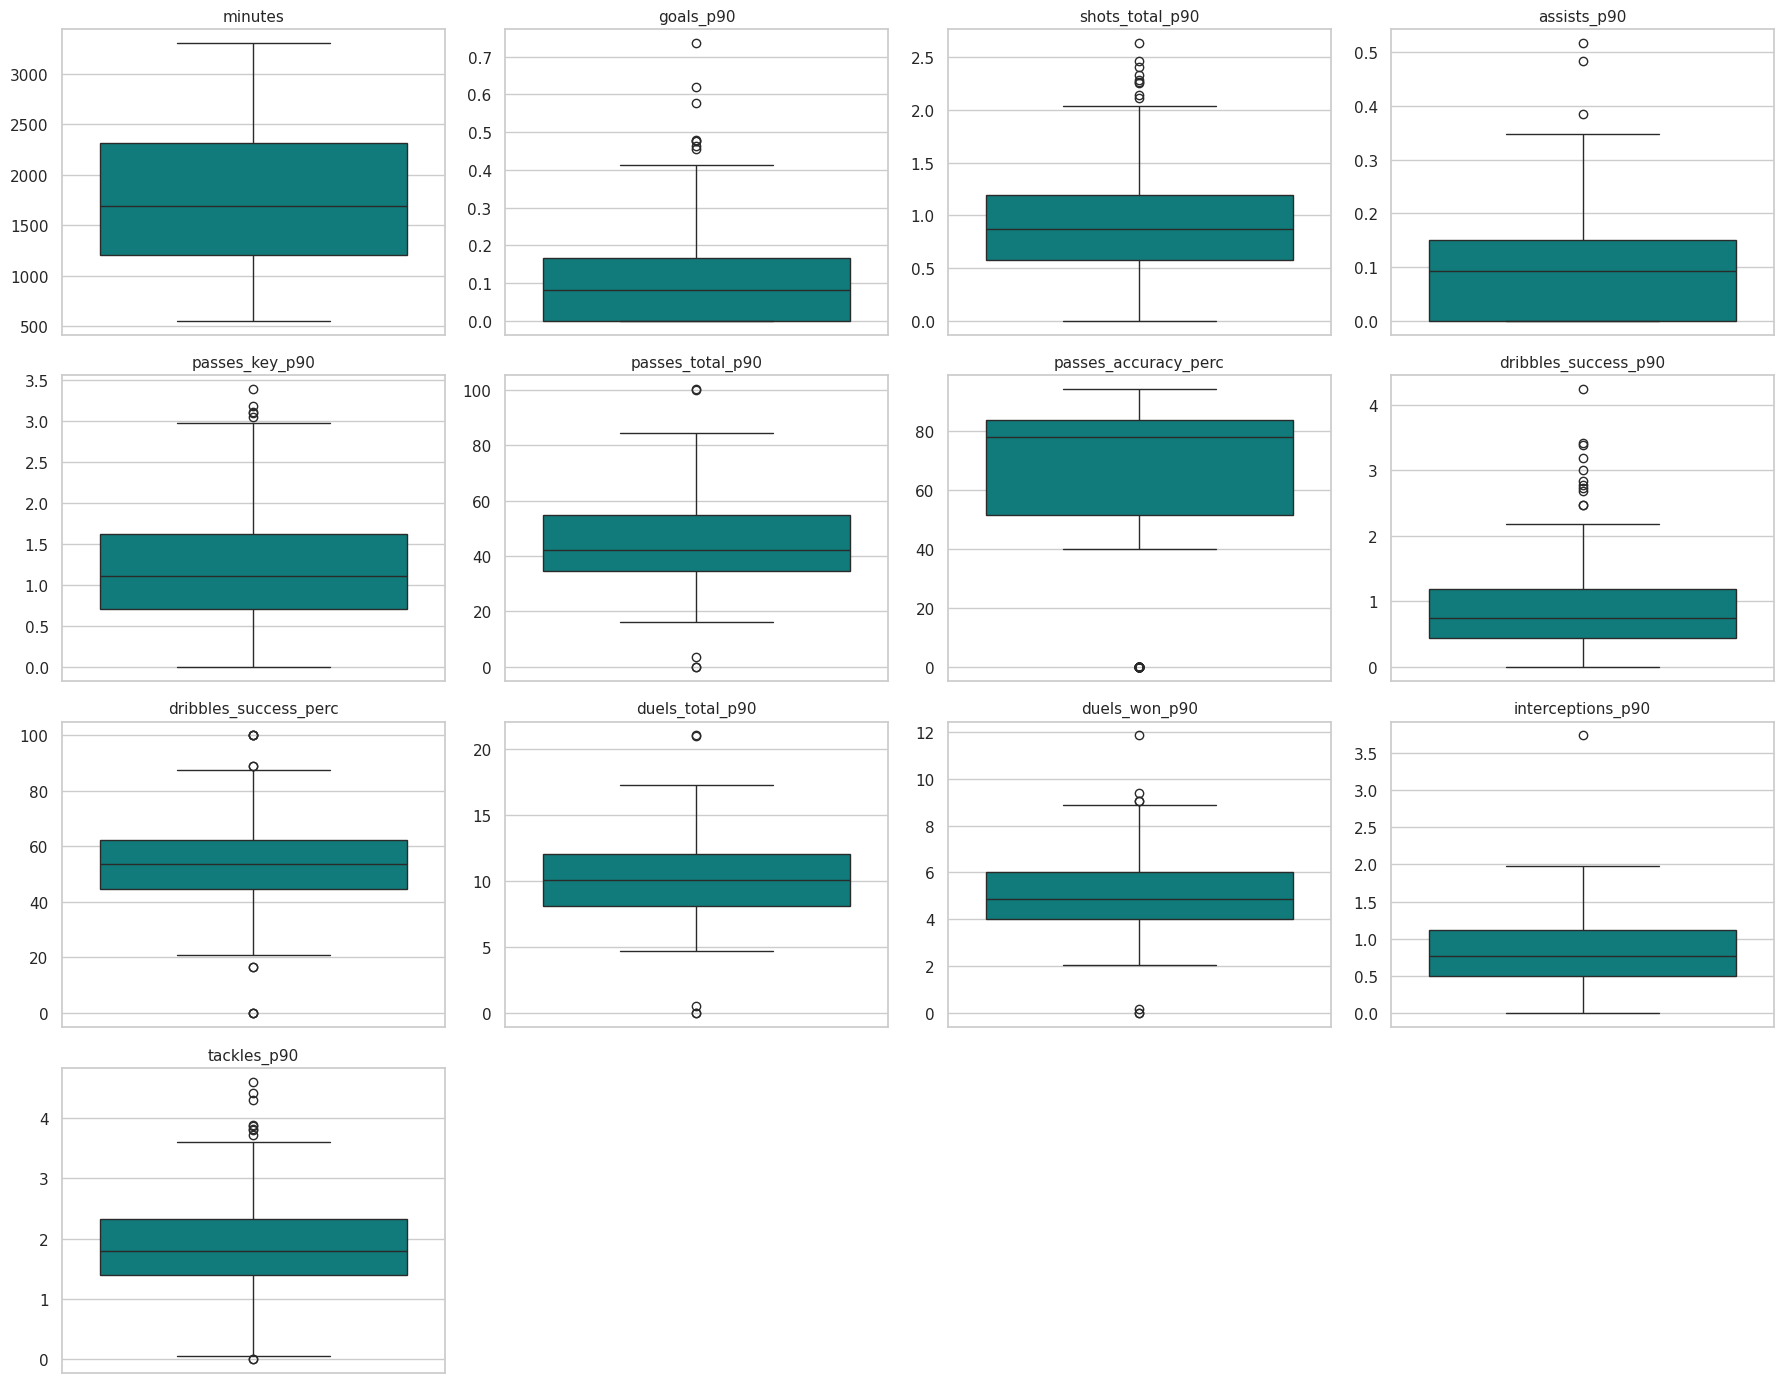

✅ Boxplot visualizations generated successfully.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Set Seaborn style ---
sns.set(style="whitegrid")

# --- Load encoded global midfielder dataset ---
try:
    df_global_encoded = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Encoded global midfielder dataset loaded successfully for boxplot analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define relevant features (excluding zero-value metrics) ---
analysis_features = [
    "minutes", "goals_p90", "shots_total_p90",
    "assists_p90", "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90",
    "interceptions_p90", "tackles_p90"
]

# --- Filter to existing columns ---
existing_features = [f for f in analysis_features if f in df_global_encoded.columns]

if not existing_features:
    print("❌ No valid features found for boxplot analysis.")
else:
    print("\n--- Generating Boxplot Visualizations ---")

    ncols = 4
    nrows = (len(existing_features) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
    axes = axes.flatten()

    for i, feature in enumerate(existing_features):
        sns.boxplot(data=df_global_encoded, y=feature, ax=axes[i], color='darkcyan')
        axes[i].set_title(f"{feature}", fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Remove unused axes
    for j in range(len(existing_features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    print("✅ Boxplot visualizations generated successfully.")


#Interpretation of Boxplots – Global Midfielders

The boxplots visualize the distribution of each metric, showing the median (line in the box), the interquartile range (the box), and potential outliers (individual points).

Here's what we can observe:

**Defensive Metrics (duels_total_p90, duels_won_p90, tackles_p90, interceptions_p90):** These boxplots show a range of values, with some outliers indicating players who perform significantly more defensive actions than the median. The boxes and whiskers suggest that while there's a core group of midfielders with similar defensive output, there are also players who specialize more heavily in defensive contributions.

**Ball Circulation/Volume (passes_total_p90, passes_key_p90):** The boxplot for `passes_total_p90` shows a relatively wide spread, with the median around the middle of the range. There are outliers on the higher end, representing midfielders with very high passing volumes. `passes_key_p90` is heavily skewed towards lower values, with many players clustered near zero and several outliers indicating players who make a significantly higher number of key passes.

**Passing Accuracy (passes_accuracy_perc):** The boxplot for `passes_accuracy_perc` shows that the majority of players have a relatively high passing accuracy, with the median in the upper half of the range. There are some outliers on the lower end, indicating players with lower passing completion rates.

**Attacking Contribution (shots_total_p90, goals_p90, assists_p90):** These boxplots are heavily skewed towards zero, with the boxes and whiskers concentrated at the lower end of the scale. The presence of numerous outliers on the higher end for all three metrics highlights players who are significantly more involved in attacking actions (shooting, scoring, assisting) than the typical midfielder.

**Ball Progression/Carrying (dribbles_success_p90, dribbles_success_perc):** The boxplots for successful dribbling metrics are heavily skewed towards lower values, similar to attacking metrics. This indicates that while most midfielders don't heavily rely on dribbling, there are outliers who are exceptional ball carriers.

**Workload (minutes):** The boxplot for `minutes` shows a distribution with a median in the middle range and a spread indicating varying levels of playing time among the midfielders who met the minimum minutes played threshold. There are outliers on both the lower and higher ends, representing players with significantly less or more playing time than the bulk of the dataset.

Overall, the boxplots reveal the presence of outliers and the varied distributions of different performance metrics, suggesting that even within the defined midfielder position, there is a range of tactical roles and specializations across Serie A, Ligue 1, and La Liga. These outliers and variations are important to consider when performing clustering.

#3. Data Cleaning- GLOBAL MIDFIELDERS

This part ensures my dataset is clean, consistent, and ready for clustering. I’ll go through key checks.

In [8]:
import pandas as pd

# --- Load the encoded global midfielder dataset ---
try:
    df_global_encoded = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Global midfielder dataset loaded successfully for data type inspection.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Ensure all column data types are displayed ---
pd.set_option("display.max_rows", None)        # Show all rows (if transposed)
pd.set_option("display.max_columns", None)     # Show all columns
pd.set_option("display.width", 1000)           # Avoid line breaks in wide tables
pd.set_option("display.max_colwidth", None)    # Don't truncate column names

# --- Display data types ---
print("\n📋 Full column data types in the encoded global midfielder dataset:")
print(df_global_encoded.dtypes)


✅ Global midfielder dataset loaded successfully for data type inspection.

📋 Full column data types in the encoded global midfielder dataset:
name                         object
position                     object
minutes                     float64
duels_total_api             float64
duels_won_api               float64
goals_total_api             float64
shots_total_api             float64
shots_on_target_api           int64
assists_total_api           float64
dribbles_attempts_api       float64
dribbles_success_api        float64
touches_total_api             int64
passes_key_api              float64
passes_total_api            float64
passes_accuracy_perc        float64
tackles_total_api           float64
interceptions_total_api     float64
shots_on_target_perc        float64
dribbles_success_perc       float64
name_clean                   object
team_clean                   object
duels_total_p90             float64
duels_won_p90               float64
goals_p90                   fl

It looks like we have correct data types as name, team, position, name_clean, team_clean, and all the team names are object. Also, shots_on_target_api and touches_total_api are integers(will be excluded as 0), the rest are float64.

I’m scanning the merged global midfielders dataset for duplicate rows. This helps prevent repeated player entries (e.g. same name and team), especially after merging or reprocessing across competitions.

In [9]:
import pandas as pd

# --- Load the encoded global midfielder dataset ---
try:
    df_global_encoded = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Encoded global midfielder dataset loaded successfully for duplicate check.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing and encoding step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# --- Check for duplicated rows ---
num_duplicates = df_global_encoded.duplicated().sum()

print(f"\n🔍 Number of duplicated rows in the global midfielder dataset: {num_duplicates}")

if num_duplicates == 0:
    print("✅ No duplicate rows found. The dataset is clean and ready for analysis.")
else:
    print("⚠️ Duplicate rows detected. Consider reviewing and removing unintended duplicates before clustering.")
    # Optional: Display duplicated rows
    # print("\nDuplicated Rows:")
    # print(df_global_encoded[df_global_encoded.duplicated(keep=False)].to_string())


✅ Encoded global midfielder dataset loaded successfully for duplicate check.

🔍 Number of duplicated rows in the global midfielder dataset: 0
✅ No duplicate rows found. The dataset is clean and ready for analysis.


0 Duplicates.

I am checking also for unique values.

In [10]:
import pandas as pd

# --- Load the encoded global midfielder dataset ---
try:
    df_global_encoded = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Global midfielder dataset loaded successfully for unique value inspection.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    print("Ensure this file was generated during your preprocessing and encoding workflow.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Check for existence of required columns ---
columns_to_check = ["name", "team"]
existing_columns = [col for col in columns_to_check if col in df_global_encoded.columns]

# --- Display unique counts if columns exist ---
if "name" in existing_columns:
    print("🔎 Unique player names:", df_global_encoded["name"].nunique())
else:
    print("⚠️ Column 'name' not found in dataset.")

if "name_clean" in df_global_encoded.columns:
    print("🔎 Unique player names (cleaned):", df_global_encoded["name_clean"].nunique())
if "team_clean" in df_global_encoded.columns:
    print("🔎 Unique teams:", df_global_encoded["team_clean"].nunique())


✅ Global midfielder dataset loaded successfully for unique value inspection.
🔎 Unique player names: 293
🔎 Unique player names (cleaned): 293
🔎 Unique teams: 56


#4. Standard Scaling

Now that I’ve merged the global midfielders dataset, I’m selecting all relevant columns for clustering — including per 90 metrics, efficiency percentages, and one-hot encoded team affiliations. I’ll apply StandardScaler across the entire feature set to normalize values for PCA and clustering.

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Load the encoded global midfielder dataset ---
try:
    df_global = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Encoded global midfielder dataset loaded for scaling.")
except FileNotFoundError:
    print("❌ File not found: 'global_midfielders_2023_24_encoded.csv'")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading file: {e}")
    exit()

# --- Define performance metrics for clustering ---
metric_cols = [
    "minutes", "goals_p90", "assists_p90", "shots_total_p90",
    "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90",
    "interceptions_p90", "tackles_p90"
]

# --- Filter valid numeric one-hot team columns ---
team_cols = [
    col for col in df_global.columns
    if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]
]

# --- Convert boolean flags to float64 for compatibility ---
for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Combine features to scale ---
features_to_scale = metric_cols + team_cols
print(f"📊 Scaling {len(features_to_scale)} features...")

# --- Create matrix and scale ---
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Remove duplicate 'minutes' before joining ---
df_scaled = df_scaled.drop(columns=["minutes"], errors="ignore")

# --- Reattach identifiers for traceability ---
id_cols = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
id_cols = [col for col in id_cols if col in df_global.columns]

df_global_scaled = df_global[id_cols].join(df_scaled)

# --- Preview results ---
print(f"\n✅ Scaled dataset shape: {df_global_scaled.shape}")
print("\n📌 Scaled Feature Distribution:")
print(df_scaled.describe().loc[["mean", "std"]])

print("\n🎯 Sample Preview:")
print(df_global_scaled[["name", "league", "minutes", "goals_p90"]].head())


✅ Encoded global midfielder dataset loaded for scaling.
📊 Scaling 13 features...

✅ Scaled dataset shape: (294, 18)

📌 Scaled Feature Distribution:
         goals_p90   assists_p90  shots_total_p90  passes_key_p90  passes_total_p90  passes_accuracy_perc  dribbles_success_p90  dribbles_success_perc  duels_total_p90  duels_won_p90  interceptions_p90   tackles_p90
mean  1.510508e-16  1.510508e-17     2.114711e-17    1.510508e-18      9.667248e-17         -7.250436e-17         -7.250436e-17           3.021015e-18    -1.450087e-16   1.208406e-16       1.208406e-16  1.087565e-16
std   1.001705e+00  1.001705e+00     1.001705e+00    1.001705e+00      1.001705e+00          1.001705e+00          1.001705e+00           1.001705e+00     1.001705e+00   1.001705e+00       1.001705e+00  1.001705e+00

🎯 Sample Preview:
             name   league  minutes  goals_p90
0     A. Candreva  Serie A   2759.0   0.698015
1    K. Strootman  Serie A   1209.0  -0.924991
2   Joan Gonzàlez  Serie A   1285.0  -0.3442

##4.1. Final feature selection- GLOBAL MIDFIELDERS

I’m scaling tactical metrics and one-hot encoded team flags across a merged global midfielders dataset. After standardizing features, I save the scaled output for reuse and generate a correlation heatmap to inspect relationships and multicollinearity before clustering.

✅ Global midfielder dataset loaded for scaling and correlation analysis.
📊 Total features to scale: 13
✅ Scaled dataset saved to 'global_midfielders_2023_24_scaled_metrics.csv'


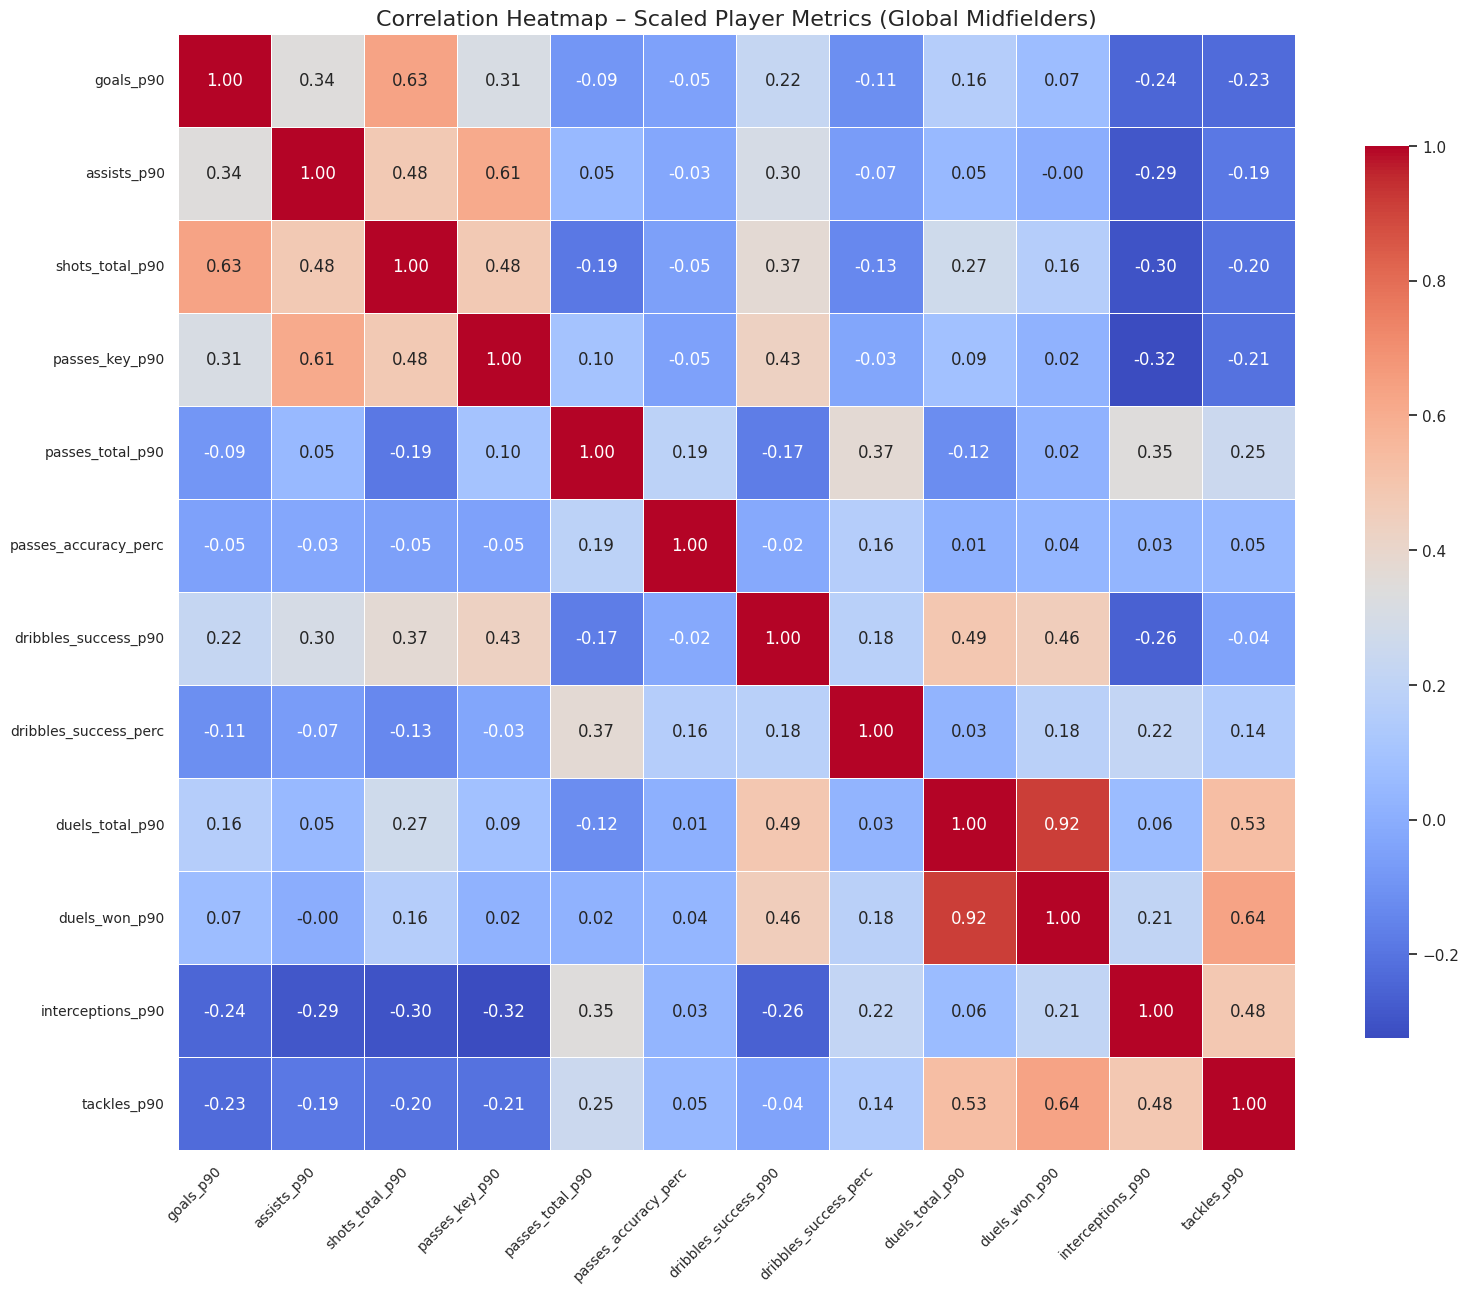

✅ Correlation heatmap generated successfully.


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Load encoded global midfielder dataset ---
try:
    df_global = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Global midfielder dataset loaded for scaling and correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading dataset: {e}")
    exit()

# --- Define tactical performance metrics ---
metric_cols = [
    "minutes", "goals_p90", "assists_p90", "shots_total_p90",
    "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_success_p90", "dribbles_success_perc",
    "duels_total_p90", "duels_won_p90",
    "interceptions_p90", "tackles_p90"
]

# --- Detect valid one-hot encoded team flags ---
team_cols = [
    col for col in df_global.columns
    if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]
]

# --- Convert boolean flags to float for scaling ---
for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Final list of features to scale ---
features_to_scale = metric_cols + team_cols
print(f"📊 Total features to scale: {len(features_to_scale)}")

# --- Apply StandardScaler ---
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Drop 'minutes' from scaled copy before join to avoid overlap ---
df_scaled_no_minutes = df_scaled.drop(columns=["minutes"], errors="ignore")

# --- Reattach identifiers for traceability ---
id_cols = ["name", "name_clean", "team_clean", "league", "position", "minutes"]
id_cols = [col for col in id_cols if col in df_global.columns]  # safeguard

df_global_mid_scaled = df_global[id_cols].join(df_scaled_no_minutes)

# --- Save to CSV for reuse downstream ---
df_global_mid_scaled.to_csv("global_midfielders_2023_24_scaled_metrics.csv", index=False)
print("✅ Scaled dataset saved to 'global_midfielders_2023_24_scaled_metrics.csv'")

# -----------------------------------------------------------------------
# 📊 Correlation Heatmap – Scaled Player Metrics (No Team Flags)
# Helps identify linear relationships among tactical features
# -----------------------------------------------------------------------

# --- Select only player-level scaled metrics for heatmap ---
clustering_features = [col for col in df_scaled.columns if not col.startswith("team_") and col != "minutes"]

# --- Generate correlation matrix ---
corr_matrix = df_scaled[clustering_features].corr()

# --- Visualize heatmap ---
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Heatmap – Scaled Player Metrics (Global Midfielders)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("✅ Correlation heatmap generated successfully.")


#Interpretation of the Correlation Heatmap – Scaled Global Midfielder Metrics

This heatmap visualizes the pairwise correlations between the scaled tactical performance metrics for global midfielders (excluding team flags).

**Strong Positive Correlations:**

*   **duels_total_p90 and duels_won_p90:** A very strong positive correlation (around 0.92) as expected. Players involved in more duels win more duels, highlighting physically active defensive midfielders.
*   **shots_total_p90 and goals_p90:** A strong positive correlation (around 0.63) shows that taking more shots leads to more goals, identifying goal-scoring midfielders.
*   **passes_key_p90 and assists_p90:** A strong positive correlation (around 0.61) confirms that midfielders who create more chances are likely to register more assists, indicating playmaking roles.

**Moderate Positive Correlations:**

*   **duels_won_p90 and tackles_p90:** A moderate positive correlation (around 0.64) suggests that winning duels is related to making tackles, showing players who are effective in direct defensive actions.
*   **duels_total_p90 and tackles_p90:** A moderate positive correlation (around 0.53) also indicates that being involved in more duels correlates with making more tackles.
*   **interceptions_p90 and tackles_p90:** A moderate positive correlation (around 0.48) between these two defensive metrics suggests players who are good at reading the game for interceptions also tend to make more tackles.
*   **dribbles_success_p90 and duels_total_p90:** A moderate positive correlation (around 0.49) suggests that successful dribblers are also involved in more duels, perhaps indicating players who carry the ball forward and then engage defensively.
*   **dribbles_success_p90 and duels_won_p90:** A moderate positive correlation (around 0.46) further supports the link between successful dribbling and winning duels.
*   **dribbles_success_p90 and passes_key_p90:** A moderate positive correlation (around 0.43) suggests that players who are good at dribbling also create key passes, potentially indicating attacking midfielders or dynamic box-to-box players.
*   **passes_total_p90 and interceptions_p90:** A moderate positive correlation (around 0.35) might suggest that midfielders involved in high-volume passing are also active in anticipating and intercepting passes, possibly indicating deep-lying playmakers with defensive duties.

**Weak or Negative Relationships:**

*   **goals_p90, assists_p90, and shots_total_p90** show moderate to weak negative correlations with defensive metrics (`duels_total_p90`, `duels_won_p90`, `interceptions_p90`, `tackles_p90`). This is expected, as players specializing in attack may have less involvement in defensive actions and vice-versa.
*   **passes_accuracy_perc** shows weak correlations with most other metrics, suggesting it is a more independent metric related to technical proficiency in passing rather than overall volume or other contributions.

**Implications for Clustering & PCA:**

*   ✅ High correlations between defensive metrics (duels, tackles, interceptions) suggest these can group together defensively oriented midfielders.
*   ✅ Correlations between attacking metrics (goals, assists, shots, key passes) indicate these will likely define attacking midfielder clusters.
*   ✅ The moderate correlations involving dribbling success with both defensive and attacking metrics suggest players with strong ball-carrying ability might bridge different tactical roles or form distinct clusters.
*   📌 Metrics with weaker correlations (like `passes_accuracy_perc`) are important for distinguishing roles based on technical precision.

#Metric Exclusion: shots_on_target_p90 & touches

In this clustering pipeline, I’ve excluded two metrics from the final feature set:

shots_on_target_p90: This metric was initially considered for capturing shooting precision, but consistent availability across merged datasets was limited. Including it would have required a full reprocessing of all league notebooks, including manual name correction and re-scaling — so it was excluded to preserve momentum.

What it could add:

Tactical clarity between volume shooters and clinical finishers

Better pairing with goals_p90 and shots_total_p90 to isolate efficiency-based goal threats

Extra separation for low-touch forwards with high finishing accuracy

What I still retain without it:

shots_total_p90 to measure shooting intent and frequency

goals_p90 as a direct scoring output

touches_total_per90: I’ve excluded touches from the feature set entirely. In forward profiling, raw touch counts tend to reflect possession dominance more than tactical role, and are often inflated by team structures or deep-lying involvement. For this analysis, I found that touches weren’t providing meaningful separation across forward roles, so I opted to leave them out.

Rationale:

Minimal tactical interpretability for clustering forward archetypes

Strong correlation with passing volume, already captured via passes_total_p90

Risk of adding noise or redundancy without improving clustering quality

This approach keeps the feature space focused, interpretable, and tactically releva

##  Feature Selection and Refinement Before PCA

Before moving into dimensionality reduction, I’m finalizing my clustering feature set. Based on the correlation heatmap and metric redundancy, I’m refining the selection as follows:

---

###  Core Metrics Retained
These features provide tactical insights into attacking contribution and ball distribution:

- `goals_p90` – representing goal threat  
- `shots_total_p90` – measuring shooting volume  
- `assists_p90` – indicating creative output  
- `passes_key_p90` – quantifying chance creation  
- `passes_total_p90` – showing passing involvement  
- `passes_accuracy_perc` – tracking possession retention

---

###  Volume-to-Efficiency Refinements
To improve interpretability and reduce redundancy, high-correlation volume metrics are replaced with execution-based indicators:

- Replaced `dribbles_attempts_p90` and `dribbles_success_p90` with:  
  → `dribbles_success_perc` – reflects technical execution efficiency

- Replaced `duels_total_p90` and `duels_won_p90` with:  
  → `duels_win_perc` – isolates physical dominance and defensive pressure effectiveness

---

###  Rationale
This refinement prevents double-counting action intensity, emphasizes execution quality over raw volume, and promotes tactical clarity in dimensionality reduction. The final feature set is compact, interpretable, and ready for scaling and PCA to surface midfielder archetypes with greater precision.


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- Load encoded global midfielder dataset ---
try:
    df_global = pd.read_csv("global_midfielders_2023_24_encoded.csv")
    print("✅ Global midfielder dataset loaded for final scaling.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_encoded.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error loading dataset: {e}")
    exit()

# --- Calculate efficiency metrics ---
df_global["dribbles_success_perc"] = (
    df_global["dribbles_success_p90"] / df_global["dribbles_attempts_p90"]
).replace([np.inf, -np.inf], np.nan).fillna(0).round(3) * 100

df_global["duels_win_perc"] = (
    df_global["duels_won_p90"] / df_global["duels_total_p90"]
).replace([np.inf, -np.inf], np.nan).fillna(0).round(3) * 100

print("✅ Created 'dribbles_success_perc' and 'duels_win_perc' for clustering.")

# --- Define final features for scaling (efficiency-driven) ---
metric_cols = [
    "goals_p90", "shots_total_p90", "assists_p90",
    "passes_key_p90", "passes_total_p90", "passes_accuracy_perc",
    "dribbles_success_perc", "duels_win_perc"
]

# --- Validate and extract one-hot encoded team columns ---
team_cols = [col for col in df_global.columns
             if col.startswith("team_") and df_global[col].dtype in ["int64", "float64", "bool"]]

for col in team_cols:
    if df_global[col].dtype == bool:
        df_global[col] = df_global[col].astype(float)

# --- Final feature set for scaling ---
features_to_scale = metric_cols + team_cols

# --- Apply StandardScaler ---
X = df_global[features_to_scale].copy()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled_array, columns=features_to_scale)

# --- Merge identifiers for traceability (avoid minutes conflict)
id_cols = ["name", "team_clean", "league", "position", "minutes"]
df_global_midfielders_scaled = df_global[id_cols].join(df_scaled)

# --- Save scaled output for PCA and clustering ---
df_global_midfielders_scaled.to_csv("global_midfielders_2023_24_scaled_metrics_final.csv", index=False)
print("✅ Final scaled dataset with refined metrics saved as 'global_midfielders_2023_24_scaled_metrics_final.csv'")


✅ Global midfielder dataset loaded for final scaling.
✅ Created 'dribbles_success_perc' and 'duels_win_perc' for clustering.
✅ Final scaled dataset with refined metrics saved as 'global_midfielders_2023_24_scaled_metrics_final.csv'


#5.1 Preprocessing-PCA (Principal Component Analysis)- GLOBAL MIDFIELDERS

✅ Global scaled midfielder dataset loaded successfully for PCA.
✅ PCA completed. Transformed dataset shape: (294, 13)


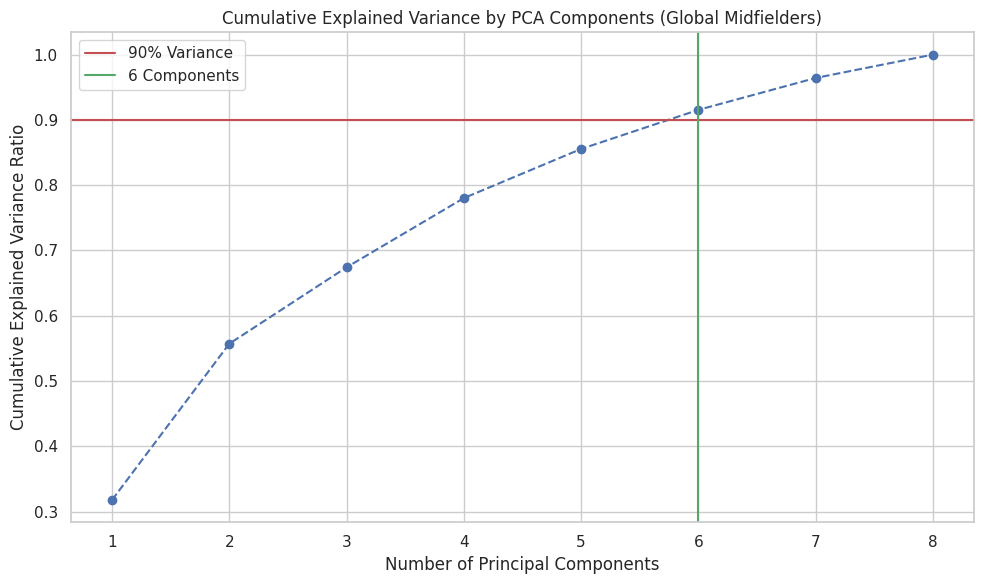

✅ Explained variance plot generated.

Explained Variance Ratio by Principal Component:
PC1: 0.3177 (Cumulative: 0.3177)
PC2: 0.2394 (Cumulative: 0.5571)
PC3: 0.1170 (Cumulative: 0.6742)
PC4: 0.1060 (Cumulative: 0.7802)
PC5: 0.0753 (Cumulative: 0.8555)
PC6: 0.0599 (Cumulative: 0.9153)
PC7: 0.0489 (Cumulative: 0.9642)
PC8: 0.0358 (Cumulative: 1.0000)

✅ Global PCA-transformed data saved as: global_midfielders_2023_24_pca_transformed.csv

📌 First 5 rows of global PCA-transformed data:
             name   team_clean   league    position  minutes       PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8
0     A. Candreva  salernitana  Serie A  Midfielder   2759.0  1.849774  0.551933  0.290455 -0.168788 -0.185718  0.953258 -0.285597 -0.426440
1    K. Strootman        genoa  Serie A  Midfielder   1209.0 -1.054784  0.507400  0.104304 -1.520221 -0.811206 -0.872039  0.310116 -0.794102
2   Joan Gonzàlez        lecce  Serie A  Midfielder   1285.0 -0.934755  0.439703  0.099311

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the scaled global midfielder feature dataset ---
try:
    df_scaled_features = pd.read_csv("global_midfielders_2023_24_scaled_metrics_final.csv")
    print("✅ Global scaled midfielder dataset loaded successfully for PCA.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_scaled_metrics_final.csv' not found.")
    print("Please ensure this file has been generated after feature scaling and efficiency metric refinement.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Drop identifier columns before PCA ---
columns_to_exclude = ["name", "team_clean", "league", "position", "minutes"]
features_only = df_scaled_features.drop(columns=columns_to_exclude, errors="ignore")

# --- Initialize and apply PCA ---
pca = PCA()
principal_components = pca.fit_transform(features_only)

# --- Create PCA DataFrame ---
df_pca = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
)

# --- Merge back identifiers for traceability ---
df_pca = pd.concat([df_scaled_features[["name", "team_clean", "league", "position", "minutes"]], df_pca], axis=1)
print(f"✅ PCA completed. Transformed dataset shape: {df_pca.shape}")

# --- Explained Variance Plot ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')

plt.title('Cumulative Explained Variance by PCA Components (Global Midfielders)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)

# Highlight 90% explained variance threshold
threshold = 0.90
n_components_90 = (pca.explained_variance_ratio_.cumsum() < threshold).sum() + 1
plt.axhline(y=threshold, color='r', linestyle='-', label=f'{int(threshold*100)}% Variance')
plt.axvline(x=n_components_90, color='g', linestyle='-', label=f'{n_components_90} Components')
plt.legend()
plt.tight_layout()
plt.show()
print("✅ Explained variance plot generated.")

# --- Print variance breakdown ---
print("\nExplained Variance Ratio by Principal Component:")
for i, variance in enumerate(pca.explained_variance_ratio_):
    cumulative = pca.explained_variance_ratio_[:i+1].sum()
    print(f"PC{i+1}: {variance:.4f} (Cumulative: {cumulative:.4f})")

# --- Save PCA output ---
pca_output_file = "global_midfielders_2023_24_pca_transformed.csv"
df_pca.to_csv(pca_output_file, index=False)
print(f"\n✅ Global PCA-transformed data saved as: {pca_output_file}")

# --- Sample preview ---
print("\n📌 First 5 rows of global PCA-transformed data:")
print(df_pca.head().to_string())


##  Explained Variance Analysis – Global Midfielders PCA

**PC1** captures **31.77%** of the total variance  
Likely reflects dominant tactical traits such as goal threat, passing volume, and distribution authority

**PC2** adds **23.94%**  
Bringing cumulative coverage to **55.71%**  
Together, PC1 and PC2 define the most discriminative tactical space

**PC3–PC5** add layered nuance:
- **PC3 (11.70%)** – progressive passing or positional depth  
- **PC4 (10.60%)** – defensive pressure, off-ball contribution  
- **PC5 (7.53%)** – execution efficiency or secondary traits

**PC6 pushes cumulative variance to 91.53%**  
Marked by the green vertical line in the visual — validates dimensional sufficiency for clustering

**PC7 (4.89%)** and **PC8 (3.58%)** provide minor refinements  
Final cumulative coverage: **100%**

---

##  Interpretation of the Visual

- The curve rises steeply for the first components, then plateaus — signaling diminishing returns  
- The **red horizontal line** marks 90% explained variance  
- The **green vertical line** at Component 6 shows the optimal cutoff for feature retention

This setup strikes the perfect balance:

 -Minimal dimensional depth  
 -Maximal tactical signal  
 -Reduced redundancy and overfitting risk  


#5.2 ELBOW METHOD- GLOBAL MIDFIELDERS

✅ Global PCA-transformed data loaded successfully for Elbow Method.
✅ Using 6 principal components (PC1–PC6) for clustering analysis.
Calculating Inertia for K from 2 to 9...
✅ Inertia values computed across K range.


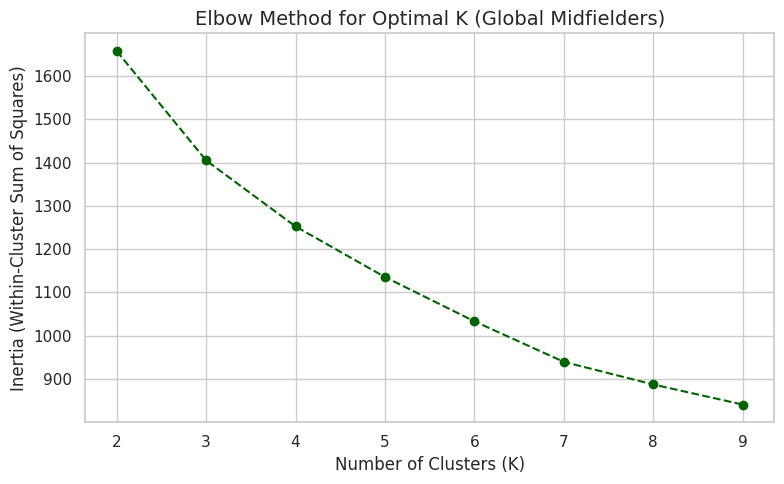

✅ Elbow Method plot generated. Inspect the 'elbow' point for optimal K estimation.


In [15]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the PCA-transformed global midfielder dataset ---
try:
    df_pca = pd.read_csv("global_midfielders_2023_24_pca_transformed.csv")
    print("✅ Global PCA-transformed data loaded successfully for Elbow Method.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Select PCA components for clustering (PC1–PC6 covers ~91.5% variance) ---
pca_components = [f"PC{i}" for i in range(1, 7)]  # PC1–PC6 based on earlier variance analysis
X_for_clustering = df_pca[pca_components].copy()
print(f"✅ Using {len(pca_components)} principal components (PC1–PC6) for clustering analysis.")

# --- Calculate inertia for different K values ---
inertia = []
K_range = range(2, 10)
print(f"Calculating Inertia for K from {min(K_range)} to {max(K_range)}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_)

print("✅ Inertia values computed across K range.")

# --- Plot Elbow Method ---
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='darkgreen')
plt.title("Elbow Method for Optimal K (Global Midfielders)", fontsize=14)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Elbow Method plot generated. Inspect the 'elbow' point for optimal K estimation.")


##  Elbow Method Interpretation – Global Midfielders

Looking at the inertia plot, there's a clear drop in within-cluster variance from **K=2 to K=4** — each additional cluster noticeably improves how compact and distinct the groups are.

But once we hit **K=4**, the curve starts to level off. Beyond that, adding more clusters doesn't give us much payoff in terms of separation. That's the classic elbow effect — the point where increasing complexity stops adding real value.

###  What this means tactically

Starting with **4 clusters** feels like a solid balance:  
- It’s enough to surface the core midfielder archetypes  
- But not so many that interpretation becomes messy or fragmented

If later on I notice some clusters mixing different tactical profiles, I might explore **K=5 or K=6** for added granularity — but **K=4** gives me a clean foundation to build from.


#5.3 Silhouette Score- GLOBAL MIDFIELDERS

✅ Global PCA-transformed data loaded successfully for Silhouette Score calculation.
✅ Using 6 principal components (PC1–PC6) for Silhouette Score evaluation.
Calculating Silhouette Scores for K from 2 to 9...
✅ Silhouette Scores computed.


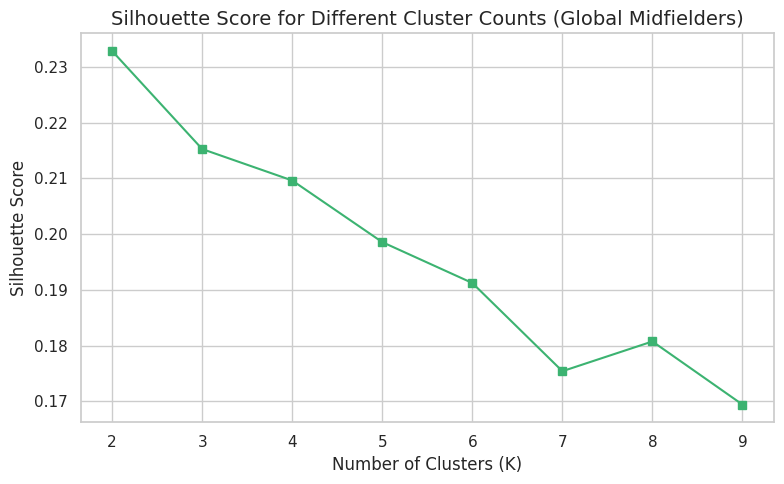

✅ Silhouette Score plot generated. Inspect the peak score to determine optimal K for tactical separation.


In [16]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the PCA-transformed global midfielder dataset ---
try:
    df_pca = pd.read_csv("global_midfielders_2023_24_pca_transformed.csv")
    print("✅ Global PCA-transformed data loaded successfully for Silhouette Score calculation.")
except FileNotFoundError:
    print("❌ Error: 'global_midfielders_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error during file loading: {e}")
    exit()

# --- Select principal components for clustering (PC1–PC6 based on variance threshold) ---
pca_components = [f"PC{i}" for i in range(1, 7)]
X_for_clustering = df_pca[pca_components].copy()
print(f"✅ Using {len(pca_components)} principal components (PC1–PC6) for Silhouette Score evaluation.")

# --- Calculate Silhouette Scores across K values ---
silhouette_scores = []
K_range = range(2, 10)
print(f"Calculating Silhouette Scores for K from {min(K_range)} to {max(K_range)}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering)
    score = silhouette_score(X_for_clustering, labels)
    silhouette_scores.append(score)

print("✅ Silhouette Scores computed.")

# --- Plot Silhouette Score trends ---
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='s', color='mediumseagreen')
plt.title("Silhouette Score for Different Cluster Counts (Global Midfielders)", fontsize=14)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Silhouette Score plot generated. Inspect the peak score to determine optimal K for tactical separation.")


##  Silhouette Score Interpretation – Final Cluster Selection (Global Midfielders)

The silhouette plot shows the strongest cluster cohesion at **K = 2**, which suggests that the midfielder pool could be cleanly split into two broad tactical categories. But while the separation is high, stopping at two groups would likely oversimplify the nuanced roles midfielders play across different leagues.

Compared to this, the **elbow method previously pointed to K = 4** — where inertia reduction starts to flatten. Although the Silhouette Score at K = 4 isn’t the highest, it still maintains moderate cohesion while allowing for richer tactical segmentation.

###  Why K = 3 Works

I’m choosing **K = 3** as the optimal number of clusters because it gives me:
- Enough flexibility to separate classic roles like deep distributors and attacking playmakers  
- Breathing room to detect hybrid or transitional profiles — players who operate between defense and creativity  
- A more expressive tactical structure without venturing into excessive fragmentation

Even though K = 2 might offer cleaner separation, **K = 3** provides the nuance needed to capture midfield versatility across league systems and player archetypes.

This sets up the next phase: clustering players, assigning tactical labels, and decoding the unique midfield roles that emerge — from engine-room orchestrators to ball-winning controllers.


#6. KMeans Training - GLOBAL MIDFIELDERS

✅ PCA-transformed midfielder data loaded.
✅ Scaled metrics loaded for centroid interpretation.
📊 Using 6 principal components for K-Means.
✅ K-Means clustering complete with K=3.
🧭 Silhouette Score (K=3): 0.215
📁 Saved PCA + cluster labels as 'global_midfielders_2023_24_pca_with_clusters.csv'

📊 Player distribution across clusters:
Cluster
0    143
1     84
2     67


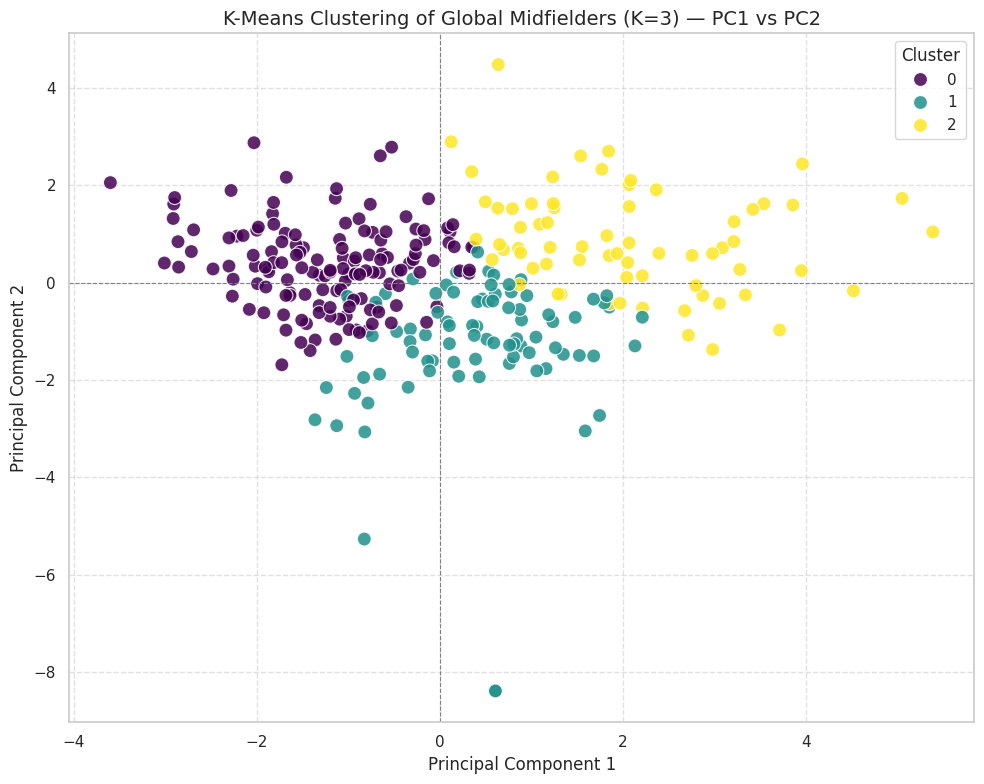

✅ Cluster visualization generated.
📁 Cluster centroids saved to 'global_midfielder_cluster_centroids.csv'

📌 Scaled Feature Averages by Cluster (Centroids):
Cluster                      0        1        2
minutes                1848.88  1624.63  1762.04
goals_p90                -0.44    -0.07     1.03
shots_total_p90          -0.54    -0.02     1.18
assists_p90              -0.44    -0.16     1.14
passes_key_p90           -0.47    -0.07     1.10
passes_total_p90          0.40    -0.76     0.08
passes_accuracy_perc      0.42    -0.85     0.17
dribbles_success_perc     0.44    -0.66    -0.10
duels_win_perc            0.42    -0.62    -0.13

🔍 Positive = Above-average contribution | Negative = Below-average


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Load PCA-transformed global midfielder data ---
try:
    df_pca = pd.read_csv("global_midfielders_2023_24_pca_transformed.csv")
    print("✅ PCA-transformed midfielder data loaded.")
except FileNotFoundError:
    print("❌ File 'global_midfielders_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# --- Load scaled tactical metrics ---
try:
    df_scaled_features = pd.read_csv("global_midfielders_2023_24_scaled_metrics_final.csv")
    print("✅ Scaled metrics loaded for centroid interpretation.")
except FileNotFoundError:
    print("❌ File 'global_midfielders_2023_24_scaled_metrics_final.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# --- Select PCA components for clustering ---
pca_components = [f"PC{i}" for i in range(1, 7)]  # Based on explained variance threshold
X_for_clustering = df_pca[pca_components].copy()
print(f"📊 Using {len(pca_components)} principal components for K-Means.")

# --- Fit K-Means clustering model ---
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)
print(f"✅ K-Means clustering complete with K={n_clusters}.")

# --- Evaluate clustering quality ---
sil_score = silhouette_score(X_for_clustering, cluster_labels)
print(f"🧭 Silhouette Score (K={n_clusters}): {sil_score:.3f}")

# --- Attach cluster labels to PCA frame ---
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters["Cluster"] = cluster_labels

# --- Save PCA + cluster labels ---
df_pca_with_clusters.to_csv("global_midfielders_2023_24_pca_with_clusters.csv", index=False)
print("📁 Saved PCA + cluster labels as 'global_midfielders_2023_24_pca_with_clusters.csv'")

# --- Display player distribution per cluster ---
print(f"\n📊 Player distribution across clusters:")
print(df_pca_with_clusters["Cluster"].value_counts().sort_index().to_string())

# --- Visualize clustering in PC1–PC2 space ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_pca_with_clusters,
    x="PC1", y="PC2", hue="Cluster",
    palette="viridis", s=100, alpha=0.85, edgecolor="w", legend="full"
)
plt.title(f"K-Means Clustering of Global Midfielders (K={n_clusters}) — PC1 vs PC2", fontsize=14)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
print("✅ Cluster visualization generated.")

# --- Interpret centroids using scaled metrics only ---
df_scaled_features["Cluster"] = cluster_labels
df_centroids = df_scaled_features.select_dtypes(include=["number"]).groupby("Cluster").mean()

# --- Save centroid matrix for role profiling ---
df_centroids.T.to_csv("global_midfielder_cluster_centroids.csv")
print("📁 Cluster centroids saved to 'global_midfielder_cluster_centroids.csv'")

# --- Display cluster centroids for interpretation ---
print("\n📌 Scaled Feature Averages by Cluster (Centroids):")
print(df_centroids.T.round(2).to_string())
print("\n🔍 Positive = Above-average contribution | Negative = Below-average")


##  Final Cluster Selection – K=3 (Global Midfielders)

After comparing both K=3 and K=4 setups, I’m opting for **K=3** as the most tactically expressive and clean clustering for global midfielders.


###  Cluster Breakdown

- **Cluster 0 – Deep-lying Playmaker**  
  These players thrive in possession-heavy roles: high passing volume, solid accuracy, and above-average physical metrics like duels and dribble efficiency.  
  They're the midfield engines that keep circulation flowing — think holding pivots, build-up anchors, or low-block metronomes who rarely push into attacking zones but control tempo from deep.

- **Cluster 1 – Positional Anchor**  
  While they show minimal involvement across attacking, possession, or physical metrics, these players are likely deployed to hold structure, absorb transitions, and offer tactical balance.  
  They're not progressors or disruptors — more like defensive shadows or safety nets, embedded in system shape rather than high-touch responsibilities.

- **Cluster 2 – Final-Third Playmaker**  
  High output across goals, assists, shot volume, and key passes.  
  These are the creative hubs operating near the opposition box — roaming No.10s, wide linkers, or free-moving interiors who specialize in unlocking space and delivering end-product.


###  Why I'm Choosing K=3

- **Clarity without clutter** — K=3 gives me strong differentiation between midfield archetypes without forcing artificial splits
- **Better silhouette cohesion** than K=4, with tighter cluster boundaries
- **Reduced visual overlap** — unlike K=4, which had blend between Clusters 1 and 3, K=3 feels cleaner
- **Tactical readability** — each cluster aligns directly with identifiable footballing roles: controller, anchor, and creator

This setup gives me a solid foundation to tag archetypes, compare across leagues, and explore team fit — without compromising on interpretability or role integrity. Next up: mapping player examples and profiling each role’s top performers ⚽📊


#7. Tactical Role Assignment by Cluster

This section assigns a descriptive tactical role to each cluster from the K-Means model. By interpreting centroid values across scaled performance metrics, we map the numerical clusters to role labels such as “Pure Finisher” or “Creative Technician.” This helps transform abstract clusters into actionable football insights.

#Why it’s important:

-Makes clustering interpretable for coaches, analysts, and scouts

-Enhances visualizations and dashboards by showing labeled roles

-Bridges the gap between data output and tactical application

Once added, these role tags can be used to filter players, highlight profiles, and communicate role-specific insights more intuitively.

In [18]:
# --- Define cluster role labels ---
cluster_roles = {
    0: "Deep-lying Playmaker",
    1: "Positional Anchor",
    2: "Final-Third Playmaker"
}

# --- Apply labels to clustered data (from PCA + scaled features or encoded set) ---
df_clustered = pd.read_csv("global_midfielders_2023_24_pca_with_clusters.csv")
df_clustered["Role_Label"] = df_clustered["Cluster"].map(cluster_roles)

# --- Optional: Sort and preview ---
df_clustered_sorted = df_clustered.sort_values("Cluster")
print("\n📌 Sample Tactical Role Assignment:")
print(df_clustered_sorted[["name", "league", "Cluster", "Role_Label"]].head())

# --- Save with role labels ---
df_clustered_sorted.to_csv("global_midfielders_2023_24_clustered_roles.csv", index=False)
print("✅ Role-labeled clustered dataset saved as 'global_midfielders_2023_24_clustered_roles.csv'")



📌 Sample Tactical Role Assignment:
              name   league  Cluster            Role_Label
292  Ander Herrera  La Liga        0  Deep-lying Playmaker
1     K. Strootman  Serie A        0  Deep-lying Playmaker
2    Joan Gonzàlez  Serie A        0  Deep-lying Playmaker
19   L. Mazzitelli  Serie A        0  Deep-lying Playmaker
26       A. Deiola  Serie A        0  Deep-lying Playmaker
✅ Role-labeled clustered dataset saved as 'global_midfielders_2023_24_clustered_roles.csv'


# 8. Normalizing performance metrics (including minutes) for consistency across visualizations and clustering

 The final role-labeled dataset contains both PC features and raw metrics like 'minutes'.
 To ensure fair comparisons and clear visuals (especially in radar/bar plots), I normalize these numeric columns so each feature is scaled between 0 and 1. This avoids dominance by high-magnitude metrics like 'minutes' and gives scouts a balanced view of player profiles.

In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Load clustered role-labeled dataset for midfielders ---
df = pd.read_csv("global_midfielders_2023_24_clustered_roles.csv")

# --- Define columns to keep for identity and labeling ---
columns_to_keep = ["name", "team_clean", "league", "position", "Cluster", "Role_Label"]

# --- Define numeric columns: minutes + 8 PCA components ---
numeric_cols = [
    "minutes", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"
]

# --- Separate numeric and other columns ---
df_numeric = df[numeric_cols].copy()
df_other = df[columns_to_keep].copy()

# --- Apply MinMax scaling to numeric features ---
scaler = MinMaxScaler()
df_scaled_numeric = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_cols)

# --- Concatenate scaled numeric columns with identity info ---
df_scaled = pd.concat([df_other, df_scaled_numeric], axis=1)

# --- Standardize merge keys for downstream compatibility ---
for col in ["name", "team_clean", "league", "position"]:
    df_scaled[col] = df_scaled[col].astype(str).str.strip().str.lower()

# --- Save enriched dataset for midfielders ---
df_scaled.to_csv("global_midfielders_2023_24_clustered_roles_scaled_enriched.csv", index=False)

print("✅ Midfielders pipeline complete using 8 PCAs. Saved as 'global_midfielders_2023_24_clustered_roles_scaled_enriched.csv'")


✅ Midfielders pipeline complete using 8 PCAs. Saved as 'global_midfielders_2023_24_clustered_roles_scaled_enriched.csv'


# 9. Merging cluster assignments with tactical role labels for enriched interpretability

 Why we're doing this: While clusters reveal statistical groupings, tactical labels translate those groups into football-relevant narratives—making it easier for scouts and analysts to interpret profiles in context.
 This step combines clustering output with human-interpretable labels to create a rich, explainable dataset ready for visualization or app integration.

In [20]:
import pandas as pd

# --- Load role-labeled dataset for validation (midfielders) ---
df_roles_checked = pd.read_csv("global_midfielders_2023_24_clustered_roles_scaled_enriched.csv")

# --- Sanity check: Ensure no missing role labels ---
missing_roles = df_roles_checked["Role_Label"].isnull().sum()
if missing_roles > 0:
    print(f"⚠️ Warning: {missing_roles} midfielders missing role labels.")
else:
    print("✅ All midfielders successfully mapped to tactical roles.")

# --- Save to a dedicated version that confirms label integrity ---
df_roles_checked.to_csv("global_midfielders_2023_24_clustered_roles_validated.csv", index=False)
print("✅ Tactical role labels validated. Saved as 'global_midfielders_2023_24_clustered_roles_validated.csv'")


✅ All midfielders successfully mapped to tactical roles.
✅ Tactical role labels validated. Saved as 'global_midfielders_2023_24_clustered_roles_validated.csv'


### 10.  PCA Component Interpretation Step

This section analyzes the correlation between each principal component (e.g., PC1, PC2) and the original encoded features in the dataset. The goal is to identify which metrics most strongly contribute to each component, allowing us to assign tactical meanings to otherwise abstract PCA axes. This step transforms technical dimensionality reduction into interpretable footballing themes, essential for labeling player clusters and enhancing scouting insights.

First I am merging the 2 datasets needed.

In [21]:
import pandas as pd

# 🔹 Load encoded metrics for midfielders
encoded_df = pd.read_csv("global_midfielders_2023_24_encoded.csv")

# 🔹 Load PCA-transformed components for midfielders
pca_df = pd.read_csv("global_midfielders_2023_24_clustered_roles_validated.csv")

# 🧩 Align dataframes: ensure row order matches before merging
# Ideally, sort or validate consistency on player name or ID beforehand

# ✅ Reset index and merge side-by-side
merged_df = pd.concat([encoded_df.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

# 💾 Save the merged dataset for midfielders
merged_df.to_csv("global_midfielders_2023_24_encoded_with_pca.csv", index=False)
print("✅ Merge complete — saved to global_midfielders_2023_24_encoded_with_pca.csv")


✅ Merge complete — saved to global_midfielders_2023_24_encoded_with_pca.csv


I am inspecting for missing values and for which columns are included on my new dataframe.

In [24]:
import pandas as pd

# 🔹 Load merged dataset for midfielders
merged_df = pd.read_csv("global_midfielders_2023_24_encoded_with_pca.csv")

# 🧾 View all column names
print("🔍 Column overview:")
print(merged_df.columns.tolist())

# 🧼 Check for missing values
missing_summary = merged_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print("\n🧼 Missing values detected:")
print(missing_summary)


🔍 Column overview:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api', 'shots_on_target_api', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_success_api', 'touches_total_api', 'passes_key_api', 'passes_total_api', 'passes_accuracy_perc', 'tackles_total_api', 'interceptions_total_api', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'duels_total_p90', 'duels_won_p90', 'goals_p90', 'shots_total_p90', 'shots_on_target_p90', 'assists_p90', 'dribbles_attempts_p90', 'dribbles_success_p90', 'touches_total_p90', 'passes_key_p90', 'passes_total_p90', 'tackles_p90', 'interceptions_p90', 'team_AS Roma', 'team_Atalanta', 'team_Bologna', 'team_Cagliari', 'team_Empoli', 'team_Fiorentina', 'team_Frosinone', 'team_Genoa', 'team_Inter', 'team_Juventus', 'team_Lazio', 'team_Lecce', 'team_Monza', 'team_Napoli', 'team_Salernitana', 'team_Sassuolo', 'team_Torino', 'team_Udinese', 'team_Verona', 'league', 'team_Le Ha

In [25]:
import pandas as pd

#  Load the merged dataset for midfielders
# This file includes both the encoded metrics and PCA components.
merged_df = pd.read_csv("global_midfielders_2023_24_encoded_with_pca.csv")

# Fill one-hot encoded team columns with 0 (absence)
team_cols = [col for col in merged_df.columns if col.startswith("team_")]
merged_df[team_cols] = merged_df[team_cols].fillna(0)

#  Confirm no missing values remain
print(" Missing values after cleanup:")
print(merged_df.isnull().sum().sum())  # Should return 0

# Save cleaned version
merged_df.to_csv("global_midfielders_2023_24_encoded_with_pca_cleaned.csv", index=False)
print("✅ Cleaned dataset exported as 'global_midfielders_2023_24_encoded_with_pca_cleaned.csv'")

#  View top rows of the cleaned dataset
print("📄 Sample preview of cleaned dataset:")
print(merged_df.head())


 Missing values after cleanup:
0
✅ Cleaned dataset exported as 'global_midfielders_2023_24_encoded_with_pca_cleaned.csv'
📄 Sample preview of cleaned dataset:
             name    position  minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  tackles_total_api  interceptions_total_api  shots_on_target_perc  dribbles_success_perc           name_clean   team_clean  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  touches_total_p90  passes_key_p90  passes_total_p90  tackles_p90  interceptions_p90 team_AS Roma team_Atalanta team_Bologna team_Cagliari team_Empoli team_Fiorentina team_Frosinone team_Genoa team_Inter team_Juventus team_Lazio team_Lecce team_Monza team_Napoli team_Salernitana team_Sassuolo team_Torino team_Udin

In [32]:
import pandas as pd

# ✅ Using the cleaned midfielders dataframe with PCA + metrics
cleaned_df = pd.read_csv("global_midfielders_2023_24_encoded_with_pca_cleaned.csv")

# 🔹 Drop previously flagged features for consistency
cols_to_drop = [
    "shots_on_target_api", "touches_total_api",
    "shots_on_target_perc", "shots_on_target_p90", "touches_total_p90"
]
cleaned_df = cleaned_df.drop(columns=cols_to_drop, errors="ignore")

# 🔹 Fill NaNs in one-hot encoded team columns
team_cols = [col for col in cleaned_df.columns if col.startswith("team_")]
cleaned_df[team_cols] = cleaned_df[team_cols].fillna(0)

# 🔹 Select only numeric columns
numeric_df = cleaned_df.select_dtypes(include="number")

#  Correlate all 8 principal components with original numeric metrics
for i in range(1, 9):
    axis = f"PC{i}"
    correlations = numeric_df.corr()[axis].sort_values(ascending=False)
    print(f"\n📈 Top features driving {axis}:")
    print(correlations.head(10))

#  Save processed version with PCA + imputed teams
cleaned_df.to_csv("global_midfielders_2023_24_encoded_with_pca_ready.csv", index=False)
print("✅ Dataset saved as 'global_midfielders_2023_24_encoded_with_pca_ready.csv'")





📈 Top features driving PC1:
PC1                        1.000000
Cluster                    0.819428
interceptions_total_api    0.144090
passes_accuracy_perc       0.133268
interceptions_p90          0.125318
duels_total_api            0.110657
passes_total_p90           0.097210
duels_won_api              0.095810
passes_total_api           0.093396
tackles_total_api          0.082510
Name: PC1, dtype: float64

📈 Top features driving PC2:
PC2                      1.000000
minutes.1                0.181548
passes_accuracy_perc     0.108839
shots_total_p90          0.058661
shots_total_api          0.055633
goals_total_api          0.035638
minutes                  0.035188
Cluster                  0.023415
goals_p90                0.018052
dribbles_success_perc    0.013735
Name: PC2, dtype: float64

📈 Top features driving PC3:
PC3                        1.000000
minutes                    0.122107
passes_total_api           0.108364
duels_total_api            0.069004
tackles_total_api


# PCA Component Interpretation – Midfielders (2023–24)

This markdown comment captures the tactical labeling of PCA axes for global midfielders, based on the correlation outputs and role relevance. These interpretations guide which components are suitable for clustering, radar charts, and scouting visualizations in the app.



🔹 **PC1 – Defensive Involvement & Ball Recovery**
Driven by interceptions, duels, tackles, and passing workload. This axis reveals players who consistently disrupt opposition play and recover possession.
 I am keeping PC1 — it represents a clear Ball-Winning Disruptor profile, tactically relevant for holding or hybrid midfielders.

🔹 **PC2 – Match Time & Basic Output Volume**
Correlates strongly with minutes played and baseline performance metrics. Reflects participation rather than playing style.
 I am not keeping PC2 — the axis lacks tactical clarity and could introduce noise. I may use it as a filter but not as a role-defining vector.

🔹 **PC3 – Defensive Backbone & Work Rate**
Combines consistent tackling, interception, and dueling metrics with match time. Strong signal of defensive effort and positional responsibility.
 I am keeping PC3 — it helps capture general engagement and complements PC1 without redundancy.

🔹 **PC4 – Final Third Attacking Output**
Features shots, goals, attacking duels, and dribble attempts. Highlights forward-oriented midfielders.
 I am keeping PC4 — it's essential for identifying creators, attacking eights, and goal-threat midfielders.

🔹 **PC5 – Defensive Precision Profile**
Focused on per 90 metrics for tackles and interceptions. Signals reactive and high-frequency pressers.
 I am keeping PC5 — it’s a precise axis for profiling energetic midfielders in pressing or transition roles.

🔹 **PC6 – Mixed Build-Up & Offensive Contribution**
Correlates with passing volume, shot creation, goals, and dribble success. Blends progression with finishing actions.
 I am keeping PC6 — it offers a composite signal for offensive distributors and chance creators.

🔹 **PC7 – Final Pass & Technical Quality**
Driven by key passes, passing accuracy, goals, and dribble success. Strong marker of playmakers and deep distributors.
 I am keeping PC7 — valuable for stylistic separation between creative midfield roles.

🔹 **PC8 – Engagement Intensity & Ball-Carrying**
Includes duels, tackles, dribbles, and pass volume. Flags box-to-box midfielders and progressive carriers.
 I am keeping PC8 — tactically meaningful and useful for scouting high-workload profiles.



Summary:
I am keeping **PC1, PC3, PC4, PC5, PC6, PC7, PC8** — these components offer strong stylistic clarity and align well with tactical role profiling.

I am **not keeping PC2**, as its interpretability is weak and it may blur cluster identity. It’s better suited for non-visual filters based on player availability or participation.

This selection ensures every retained axis supports clear scouting narratives and role visualizations — consistent with my framework for defenders.



# 11. Use of raw metrics for my app.

Now I will also need to use raw metrics from my individual league notebooks in order to include them on my app and see the actual numbers and percentages for the midfielders, as the global_midfielders_2023_24_merged_app_ready.csv includes scaled metrics.

In [28]:
import pandas as pd

# 🔹 Load preprocessed midfielder datasets
seriea_df = pd.read_csv("seriea_midfielders_2023_24_preprocessed.csv")
ligue1_df = pd.read_csv("ligue1_midfielders_2023_24_preprocessed.csv")
laliga_df = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")

# 🔹 Add league labels for context
seriea_df["league"] = "Serie A"
ligue1_df["league"] = "Ligue 1"
laliga_df["league"] = "La Liga"

# 🔹 Merge datasets vertically
merged_raw_df = pd.concat([seriea_df, ligue1_df, laliga_df], ignore_index=True)

# 🔹 Export unified raw metrics with player names intact
output_path = "merged_global_midfielders_raw_metrics_with_names.csv"
merged_raw_df.to_csv(output_path, index=False)

print(f"✅ Raw metrics export complete → {output_path}")


✅ Raw metrics export complete → merged_global_midfielders_raw_metrics_with_names.csv


Comparing Column Structures of the Three League Datasets

In [29]:
import pandas as pd

# 🔹 Load preprocessed midfielder datasets
seriea_df = pd.read_csv("seriea_midfielders_2023_24_preprocessed.csv")
ligue1_df = pd.read_csv("ligue1_midfielders_2023_24_preprocessed.csv")
laliga_df = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")

# 🔍 Convert column lists to sets for easy comparison
seriea_cols = set(seriea_df.columns)
ligue1_cols = set(ligue1_df.columns)
laliga_cols = set(laliga_df.columns)

# 📌 Find common columns across all three leagues
common_cols = seriea_cols & ligue1_cols & laliga_cols
print(f"✅ Columns common to all three leagues ({len(common_cols)}):\n", sorted(common_cols))

# 🏳️ League-specific column audit
print("\n🇮🇹 Columns only in Serie A:")
print(sorted(seriea_cols - ligue1_cols - laliga_cols))

print("\n🇫🇷 Columns only in Ligue 1:")
print(sorted(ligue1_cols - seriea_cols - laliga_cols))

print("\n🇪🇸 Columns only in La Liga:")
print(sorted(laliga_cols - seriea_cols - ligue1_cols))


✅ Columns common to all three leagues (35):
 ['assists_p90', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_attempts_p90', 'dribbles_success_api', 'dribbles_success_p90', 'dribbles_success_perc', 'duels_total_api', 'duels_total_p90', 'duels_won_api', 'duels_won_p90', 'goals_p90', 'goals_total_api', 'interceptions_p90', 'interceptions_total_api', 'minutes', 'name', 'name_clean', 'passes_accuracy_perc', 'passes_key_api', 'passes_key_p90', 'passes_total_api', 'passes_total_p90', 'position', 'shots_on_target_api', 'shots_on_target_p90', 'shots_on_target_perc', 'shots_total_api', 'shots_total_p90', 'tackles_p90', 'tackles_total_api', 'team', 'team_clean', 'touches_total_api', 'touches_total_p90']

🇮🇹 Columns only in Serie A:
[]

🇫🇷 Columns only in Ligue 1:
[]

🇪🇸 Columns only in La Liga:
[]


Merging the 3 leagues , adding the league column and inspecting for missing values.

In [30]:
import pandas as pd

# 🔹 Load and tag each DataFrame with its league
seriea_df = pd.read_csv("seriea_midfielders_2023_24_preprocessed.csv")
ligue1_df = pd.read_csv("ligue1_midfielders_2023_24_preprocessed.csv")
laliga_df = pd.read_csv("laliga_midfielders_2023_24_preprocessed.csv")

seriea_df["league"] = "Serie A"
ligue1_df["league"] = "Ligue 1"
laliga_df["league"] = "La Liga"

# 🔹 Merge them into one unified DataFrame
merged_df = pd.concat([seriea_df, ligue1_df, laliga_df], ignore_index=True)
print(f"📊 Merged shape: {merged_df.shape}")
print(merged_df.head())

# 🔍 Inspect for missing values
missing_summary = merged_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print(f"\n🚨 Columns with missing values ({len(missing_summary)}):")
print(missing_summary.sort_values(ascending=False))

# 📁 Export merged raw midfielder dataset for later use
output_path = "merged_global_midfielders_raw_metrics_with_names.csv"
merged_df.to_csv(output_path, index=False)
print(f"\n✅ Midfielder dataset saved → {output_path}")


📊 Merged shape: (293, 36)
            name         team    position  minutes  duels_total_api  duels_won_api  goals_total_api  shots_total_api  shots_on_target_api  assists_total_api  dribbles_attempts_api  dribbles_success_api  touches_total_api  passes_key_api  passes_total_api  passes_accuracy_perc  tackles_total_api  interceptions_total_api  shots_on_target_perc  dribbles_success_perc        name_clean   team_clean  duels_total_p90  duels_won_p90  goals_p90  shots_total_p90  shots_on_target_p90  assists_p90  dribbles_attempts_p90  dribbles_success_p90  touches_total_p90  passes_key_p90  passes_total_p90  tackles_p90  interceptions_p90   league
0    A. Candreva  Salernitana  Midfielder   2759.0            143.0           76.0              6.0             43.0                    0                6.0                   36.0                  15.0                  0            60.0            1141.0                  72.4               18.0                      7.0                   0.0  

#  Dropping redundant and derivable columns:

 - Raw totals used only for percent calculations (e.g. shots, dribbles)
 - FBref metadata and duplicate identifiers
 - Source-specific accuracy metrics already derivable from components
 - Percent columns that will be re-derived post-normalization

In [31]:
import pandas as pd

# 🔹 Load cleaned and merged midfielders dataset
df = pd.read_csv("merged_global_midfielders_raw_metrics_with_names.csv")

# 🔹 Drop rows where flagged columns contain missing values

cols_to_drop = [
    "shots_on_target_api", "touches_total_api",
    "shots_on_target_perc", "shots_on_target_p90", "touches_total_p90"
]
df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

# ✅ Confirm new shape
print(f"📉 Shape after cleaning: {df.shape}")

# 🔹 Save the cleaned version
df.to_csv("merged_global_midfielders_raw_metrics_cleaned.csv", index=False)
print("✅ Cleaned dataset saved as 'merged_global_midfielders_raw_metrics_cleaned.csv'")


📉 Shape after cleaning: (293, 31)
✅ Cleaned dataset saved as 'merged_global_midfielders_raw_metrics_cleaned.csv'


###  Feature Cleanup and Tactical Consolidation

The following step refines the midfielder dataset before normalization and clustering. I’m removing redundant or derived columns , collapsing overlapping actions into a unified metric, and dropping raw totals where p90 versions exist. This ensures that inputs are interpretable, pace-adjusted, and tactically relevant , creating a cleaner foundation for role profiling and radar visualizations.


#12. Final dataset with raw metrics and PCA+Role Labels

Merging the raw data with the CSV that contains non-numerical values, role labels and the PCAs with the selected metrics.

First I am checking the existing columns of my 2 datasets and see which ones I need to keep, drop, rename and re-calculate.

In [33]:
import pandas as pd

# 🔹 Load both midfielder datasets
raw_df = pd.read_csv("merged_global_midfielders_raw_metrics_cleaned.csv")
pca_df = pd.read_csv("global_midfielders_2023_24_encoded_with_pca_ready.csv")

# 🔍 Inspect column lists from each dataset
print("\n🔎 Columns in raw metrics dataset:")
print(raw_df.columns.tolist())

print("\n🧪 Columns in PCA dataset:")
print(pca_df.columns.tolist())



🔎 Columns in raw metrics dataset:
['name', 'team', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_success_api', 'passes_key_api', 'passes_total_api', 'passes_accuracy_perc', 'tackles_total_api', 'interceptions_total_api', 'dribbles_success_perc', 'name_clean', 'team_clean', 'duels_total_p90', 'duels_won_p90', 'goals_p90', 'shots_total_p90', 'assists_p90', 'dribbles_attempts_p90', 'dribbles_success_p90', 'passes_key_p90', 'passes_total_p90', 'tackles_p90', 'interceptions_p90', 'league']

🧪 Columns in PCA dataset:
['name', 'position', 'minutes', 'duels_total_api', 'duels_won_api', 'goals_total_api', 'shots_total_api', 'assists_total_api', 'dribbles_attempts_api', 'dribbles_success_api', 'passes_key_api', 'passes_total_api', 'passes_accuracy_perc', 'tackles_total_api', 'interceptions_total_api', 'dribbles_success_perc', 'name_clean', 'team_clean', 'duels_total_p90', 'duels_won_p90', 

Merging the 2 datasets.

In [34]:
import pandas as pd

# Load datasets
metrics_df = pd.read_csv("merged_global_midfielders_raw_metrics_cleaned.csv")
pca_df = pd.read_csv("global_midfielders_2023_24_encoded_with_pca_ready.csv")

# Merge on 'name_clean' to maximize alignment
merged_df = pd.merge(metrics_df, pca_df, on="name_clean", how="outer", suffixes=('_metrics', '_pca'))

# Fill missing 'name' values using either source
merged_df['name'] = merged_df['name_metrics'].combine_first(merged_df['name_pca'])

# Save merged file
merged_df.to_csv("global_midfielders_2023_24_merged_for_column_selection.csv", index=False)

# Print column list for review
print("📋 Columns in merged dataset:")
for col in merged_df.columns:
    print("-", col)


📋 Columns in merged dataset:
- name_metrics
- team
- position_metrics
- minutes_metrics
- duels_total_api_metrics
- duels_won_api_metrics
- goals_total_api_metrics
- shots_total_api_metrics
- assists_total_api_metrics
- dribbles_attempts_api_metrics
- dribbles_success_api_metrics
- passes_key_api_metrics
- passes_total_api_metrics
- passes_accuracy_perc_metrics
- tackles_total_api_metrics
- interceptions_total_api_metrics
- dribbles_success_perc_metrics
- name_clean
- team_clean_metrics
- duels_total_p90_metrics
- duels_won_p90_metrics
- goals_p90_metrics
- shots_total_p90_metrics
- assists_p90_metrics
- dribbles_attempts_p90_metrics
- dribbles_success_p90_metrics
- passes_key_p90_metrics
- passes_total_p90_metrics
- tackles_p90_metrics
- interceptions_p90_metrics
- league_metrics
- name_pca
- position_pca
- minutes_pca
- duels_total_api_pca
- duels_won_api_pca
- goals_total_api_pca
- shots_total_api_pca
- assists_total_api_pca
- dribbles_attempts_api_pca
- dribbles_success_api_pca
- p

I am renaming, re-ordering my columns to look nicer on my app. Also I m calculating some new metrics.

In [35]:
import pandas as pd

# Load merged dataset
df = pd.read_csv("global_midfielders_2023_24_merged_for_column_selection.csv")

# === Step 1: Calculated Metrics ===
df["Duels Won per 90 (%)"] = (df["duels_won_p90_metrics"] / df["duels_total_p90_metrics"]) * 100
df["Dribbles per 90 (%)"] = (df["dribbles_success_p90_metrics"] / df["dribbles_attempts_p90_metrics"]) * 100

# === Step 2: Rename Columns ===
rename_map = {
    "name_clean": "Player Name",
    "league_metrics": "League",
    "team_clean_metrics": "Club",
    "position_metrics": "Position",
    "Role_Label": "Tactical Role",
    "goals_p90_metrics": "Goals per 90",
    "goals_total_api_metrics": "Goals Total",
    "shots_total_p90_metrics": "Shots per 90",
    "shots_total_api_metrics": "Shots Total",
    "assists_p90_metrics": "Assists per 90",
    "assists_total_api_metrics": "Assists Total",
    "passes_key_p90_metrics": "Key Passes per 90",
    "passes_total_p90_metrics": "Total Passes per 90",
    "passes_accuracy_perc_metrics": "Pass Accuracy (%)",
    "tackles_p90_metrics": "Tackles per 90",
    "tackles_total_api_metrics": "Tackles Total",
    "interceptions_p90_metrics": "Interceptions per 90",
    "interceptions_total_api_metrics": "Interceptions Total",
    "PC1": "Defensive Involvement & Ball Recovery",
    "PC3": "Defensive Involvement & Consistency",
    "PC4": "Final Third/Attacking Contribution",
    "PC5": "Defensive Pressing",
    "PC6": "Build-Up & Offensive Contribution",
    "PC7": "Passing & Technical Quality",
    "PC8": "Intensity & Ball-Carrying"
}
df = df.rename(columns=rename_map)

# === Step 3: Drop Unused Columns ===
drop_cols = [col for col in df.columns if col.startswith("team_") or col.endswith(".1") or "_pca" in col or col == "PC2"]
df = df.drop(columns=drop_cols, errors="ignore")

# === Step 4: Reorder Columns ===
ordered_columns = [
    "Player Name", "League", "Club", "Position", "Tactical Role",
    "Goals per 90", "Goals Total",
    "Shots per 90", "Shots Total",
    "Assists per 90", "Assists Total",
    "Duels Won per 90 (%)", "Dribbles per 90 (%)",
    "Key Passes per 90", "Total Passes per 90", "Pass Accuracy (%)",
    "Tackles per 90", "Tackles Total",
    "Interceptions per 90", "Interceptions Total",
    "Defensive Involvement & Ball Recovery", "Defensive Involvement & Consistency",
    "Final Third/Attacking Contribution", "Defensive Pressing",
    "Build-Up & Offensive Contribution", "Passing & Technical Quality",
    "Intensity & Ball-Carrying"
]
df = df[[col for col in ordered_columns if col in df.columns]]

# === Step 5: Save Final Dataset ===
df.to_csv("global_midfielders_2023_24_profiled_final.csv", index=False)
print("✅ Final dataset saved as 'global_midfielders_2023_24_profiled_final.csv'")
print("\n📋 Columns in Final Dataset:")
for col in df.columns:
    print("-", col)


✅ Final dataset saved as 'global_midfielders_2023_24_profiled_final.csv'

📋 Columns in Final Dataset:
- Player Name
- League
- Club
- Position
- Tactical Role
- Goals per 90
- Goals Total
- Shots per 90
- Shots Total
- Assists per 90
- Assists Total
- Duels Won per 90 (%)
- Dribbles per 90 (%)
- Key Passes per 90
- Total Passes per 90
- Pass Accuracy (%)
- Tackles per 90
- Tackles Total
- Interceptions per 90
- Interceptions Total
- Defensive Involvement & Ball Recovery
- Defensive Involvement & Consistency
- Final Third/Attacking Contribution
- Defensive Pressing
- Build-Up & Offensive Contribution
- Passing & Technical Quality
- Intensity & Ball-Carrying
